# CFL using Reverberations 

**Source**: https://cfl.readthedocs.io/en/latest/index.html :
*Based off of the El Nino example of CFL*

#### Table of Contents
* [Initial Setup](#Initial-Setup)
* [Flipped](#Flipped)
* [Visualized Macros](#Visualized-Macros)
* [Prediction from Macrostates](#Prediction-from-Macrostates)
* [Reshape](#Reshape)
* [Flipped Visualizations](#Flipped-Visualizations)
* [Line Segments](#Line-Segments)

In [1]:
import cfl
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import IPython.display
import numpy as np
import matplotlib.pyplot as plt
import copy
import scipy.ndimage
import scipy.signal as signal

from sklearn.preprocessing import StandardScaler
from cfl.experiment import Experiment
from sklearn.cluster import KMeans 
from scipy.io import wavfile
from keras import callbacks
from ipywidgets import interact, interactive, fixed
from pyAudioAnalysis import audioBasicIO
from prettytable import PrettyTable
from random import randrange
from scipy.io import wavfile
from scipy.signal import butter, lfilter


%matplotlib inline


In [2]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    return b, a

#########################################################################################################################

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

#########################################################################################################################

def overlap(X, window_size, window_step):
    """
    Create an overlapped version of X
    Parameters
    ----------
    X : ndarray, shape=(n_samples,)
        Input signal to window and overlap
    window_size : int
        Size of windows to take
    window_step : int
        Step size between windows
    Returns
    -------
    X_strided : shape=(n_windows, window_size)
        2D array of overlapped X
    """
    if window_size % 2 != 0:
        raise ValueError("Window size must be even!")
    # Make sure there are an even number of windows before stridetricks
    append = np.zeros((window_size - len(X) % window_size))
    X = np.hstack((X, append))

    ws = window_size
    ss = window_step
    a = X

    valid = len(a) - ws
    nw = (valid) // ss
    out = np.ndarray((nw, ws), dtype=a.dtype)

    for i in np.arange(nw):
        # "slide" the window along the samples
        start = i * ss
        stop = start + ws
        out[i] = a[start:stop]

    return out

#########################################################################################################################

def stft(
    X, fftsize=128, step=65, mean_normalize=True, real=False, compute_onesided=True
):
    """
    Compute STFT for 1D real valued input X
    """
    if real:
        local_fft = np.fft.rfft
        cut = -1
    else:
        local_fft = np.fft.fft
        cut = None
    if compute_onesided:
        cut = fftsize // 2
    if mean_normalize:
        X -= X.mean()

    X = overlap(X, fftsize, step)

    size = fftsize
    win = 0.54 - 0.46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))
    X = X * win[None]
    X = local_fft(X)[:, :cut]
    return X

#########################################################################################################################

def pretty_spectrogram(d, log=True, thresh=5, fft_size=512, step_size=64):
    """
    creates a spectrogram
    log: take the log of the spectrgram
    thresh: threshold minimum power for log spectrogram
    """
    specgram = np.abs(
        stft(d, fftsize=fft_size, step=step_size, real=False, compute_onesided=True)
    )

    if log == True:
        specgram /= specgram.max()  # volume normalize to max 1
        specgram = np.log10(specgram)  # take log
        specgram[
            specgram < -thresh
        ] = -thresh  # set anything less than the threshold as the threshold
    else:
        specgram[
            specgram < thresh
        ] = thresh  # set anything less than the threshold as the threshold

    return specgram


##################################################
# Also mostly modified or taken from https://gist.github.com/kastnerkyle/179d6e9a88202ab0a2fe
def invert_pretty_spectrogram(
    X_s, log=True, fft_size=512, step_size=512 / 4, n_iter=10
):

    if log == True:
        X_s = np.power(10, X_s)

    X_s = np.concatenate([X_s, X_s[:, ::-1]], axis=1)
    X_t = iterate_invert_spectrogram(X_s, fft_size, step_size, n_iter=n_iter)
    return X_t

#########################################################################################################################

def iterate_invert_spectrogram(X_s, fftsize, step, n_iter=10, verbose=False):
    reg = np.max(X_s) / 1e8
    X_best = copy.deepcopy(X_s)
    for i in range(n_iter):
        if verbose:
            print("Runnning iter %i" % i)
        if i == 0:
            X_t = invert_spectrogram(
                X_best, step, calculate_offset=True, set_zero_phase=True
            )
        else:
            X_t = invert_spectrogram(
                X_best, step, calculate_offset=True, set_zero_phase=False
            )
        est = stft(X_t, fftsize=fftsize, step=step, compute_onesided=False)
        phase = est / np.maximum(reg, np.abs(est))
        X_best = X_s * phase[: len(X_s)]
    X_t = invert_spectrogram(X_best, step, calculate_offset=True, set_zero_phase=False)
    return np.real(X_t)

#########################################################################################################################

def invert_spectrogram(X_s, step, calculate_offset=True, set_zero_phase=True):
    size = int(X_s.shape[1] // 2)
    wave = np.zeros((X_s.shape[0] * step + size))
    # Getting overflow warnings with 32 bit...
    wave = wave.astype("float64")
    total_windowing_sum = np.zeros((X_s.shape[0] * step + size))
    win = 0.54 - 0.46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))

    est_start = int(size // 2) - 1
    est_end = est_start + size
    for i in range(X_s.shape[0]):
        wave_start = int(step * i)
        wave_end = wave_start + size
        if set_zero_phase:
            spectral_slice = X_s[i].real + 0j
        else:
            # already complex
            spectral_slice = X_s[i]

        # Don't need fftshift due to different impl.
        wave_est = np.real(np.fft.ifft(spectral_slice))[::-1]
        if calculate_offset and i > 0:
            offset_size = size - step
            if offset_size <= 0:
                print(
                    "WARNING: Large step size >50\% detected! "
                    "This code works best with high overlap - try "
                    "with 75% or greater"
                )
                offset_size = step
            offset = xcorr_offset(
                wave[wave_start : wave_start + offset_size],
                wave_est[est_start : est_start + offset_size],
            )
        else:
            offset = 0
        wave[wave_start:wave_end] += (
            win * wave_est[est_start - offset : est_end - offset]
        )
        total_windowing_sum[wave_start:wave_end] += win
    wave = np.real(wave) / (total_windowing_sum + 1e-6)
    return wave

#########################################################################################################################

def xcorr_offset(x1, x2):
    x1 = x1 - x1.mean()
    x2 = x2 - x2.mean()
    frame_size = len(x2)
    half = frame_size // 2
    corrs = np.convolve(x1.astype("float32"), x2[::-1].astype("float32"))
    corrs[:half] = -1e30
    corrs[-half:] = -1e30
    offset = corrs.argmax() - len(x1)
    return offset

#########################################################################################################################

def make_mel(spectrogram, mel_filter, shorten_factor=1):
    mel_spec = np.transpose(mel_filter).dot(np.transpose(spectrogram))
    mel_spec = scipy.ndimage.zoom(
        mel_spec.astype("float32"), [1, 1.0 / shorten_factor]
    ).astype("float16")
    mel_spec = mel_spec[:, 1:-1]  # a little hacky but seemingly needed for clipping
    return mel_spec

#########################################################################################################################

def mel_to_spectrogram(mel_spec, mel_inversion_filter, spec_thresh, shorten_factor):
    """
    takes in an mel spectrogram and returns a normal spectrogram for inversion 
    """
    mel_spec = mel_spec + spec_thresh
    uncompressed_spec = np.transpose(np.transpose(mel_spec).dot(mel_inversion_filter))
    uncompressed_spec = scipy.ndimage.zoom(
        uncompressed_spec.astype("float32"), [1, shorten_factor]
    ).astype("float16")
    uncompressed_spec = uncompressed_spec - 4
    return uncompressed_spec

#########################################################################################################################

def hz2mel(hz):
    """Convert a value in Hertz to Mels
    :param hz: a value in Hz. This can also be a numpy array, conversion proceeds element-wise.
    :returns: a value in Mels. If an array was passed in, an identical sized array is returned.
    """
    return 2595 * np.log10(1 + hz / 700.0)

#########################################################################################################################

def mel2hz(mel):
    """Convert a value in Mels to Hertz
    :param mel: a value in Mels. This can also be a numpy array, conversion proceeds element-wise.
    :returns: a value in Hertz. If an array was passed in, an identical sized array is returned.
    """
    return 700 * (10 ** (mel / 2595.0) - 1)

#########################################################################################################################

def get_filterbanks(nfilt=20, nfft=512, samplerate=16000, lowfreq=0, highfreq=None):
    """Compute a Mel-filterbank. The filters are stored in the rows, the columns correspond
    to fft bins. The filters are returned as an array of size nfilt * (nfft/2 + 1)
    :param nfilt: the number of filters in the filterbank, default 20.
    :param nfft: the FFT size. Default is 512.
    :param samplerate: the samplerate of the signal we are working with. Affects mel spacing.
    :param lowfreq: lowest band edge of mel filters, default 0 Hz
    :param highfreq: highest band edge of mel filters, default samplerate/2
    :returns: A numpy array of size nfilt * (nfft/2 + 1) containing filterbank. Each row holds 1 filter.
    """
    highfreq = highfreq or samplerate / 2
    assert highfreq <= samplerate / 2, "highfreq is greater than samplerate/2"

    # compute points evenly spaced in mels
    lowmel = hz2mel(lowfreq)
    highmel = hz2mel(highfreq)
    melpoints = np.linspace(lowmel, highmel, nfilt + 2)
    # our points are in Hz, but we use fft bins, so we have to convert
    #  from Hz to fft bin number
    bin = np.floor((nfft + 1) * mel2hz(melpoints) / samplerate)

    fbank = np.zeros([nfilt, nfft // 2])
    for j in range(0, nfilt):
        for i in range(int(bin[j]), int(bin[j + 1])):
            fbank[j, i] = (i - bin[j]) / (bin[j + 1] - bin[j])
        for i in range(int(bin[j + 1]), int(bin[j + 2])):
            fbank[j, i] = (bin[j + 2] - i) / (bin[j + 2] - bin[j + 1])
    return fbank

#########################################################################################################################

def create_mel_filter(
    fft_size, n_freq_components=64, start_freq=300, end_freq=8000, samplerate=44100
):
    """
    Creates a filter to convolve with the spectrogram to get out mels

    """
    mel_inversion_filter = get_filterbanks(
        nfilt=n_freq_components,
        nfft=fft_size,
        samplerate=samplerate,
        lowfreq=start_freq,
        highfreq=end_freq,
    )
    # Normalize filter
    mel_filter = mel_inversion_filter.T / mel_inversion_filter.sum(axis=1)

    return mel_filter, mel_inversion_filter

**********
*********
# Initial Setup
[Top](#CFL-using-Reverberations)

In [3]:
rate, data = wavfile.read('creaking_mono.wav')
#rate, data = wavfile.read('edend_intro_mono.wav')
time = np.arange(0, len(data)) / rate
len(data) / rate

C:\Users\tanse\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  """Entry point for launching an IPython kernel.


5.0986666666666665

In [4]:
rate2, data2 = wavfile.read('creaking_reverb.wav')
# rate2, data2 = wavfile.read('edend_reverb.wav')
time2 = np.arange(0, len(data2)) / rate2
len(data2) / rate2

C:\Users\tanse\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  """Entry point for launching an IPython kernel.


5.0986666666666665

In [5]:
### Parameters ###
fft_size = 2**12# window size for the FFT
step_size = fft_size // 16  # distance to slide along the window (in time)
spec_thresh = 4  # threshold for spectrograms (lower filters out more noise)

Text(0.5, 1.0, 'Spectrogram')

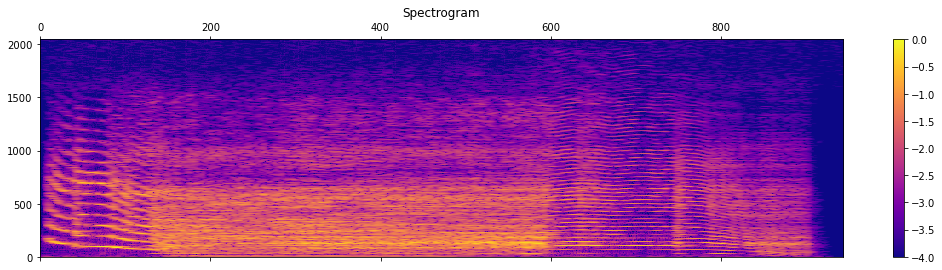

In [6]:
spec = pretty_spectrogram(
    data.astype("float64"),
    fft_size=fft_size,
    step_size=step_size,
    log=True,
    thresh=spec_thresh,
)


spec1a, spec1b = np.split(spec,2)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 4))
cax = ax.matshow(
    np.transpose(spec),
    interpolation="nearest",
    aspect="auto",
    cmap='plasma',
    origin="lower",
)
fig.colorbar(cax)
plt.title("Spectrogram")

In [7]:
IPython.display.Audio(data = data, rate = rate)

Text(0.5, 1.0, 'Reverb Spectrogram')

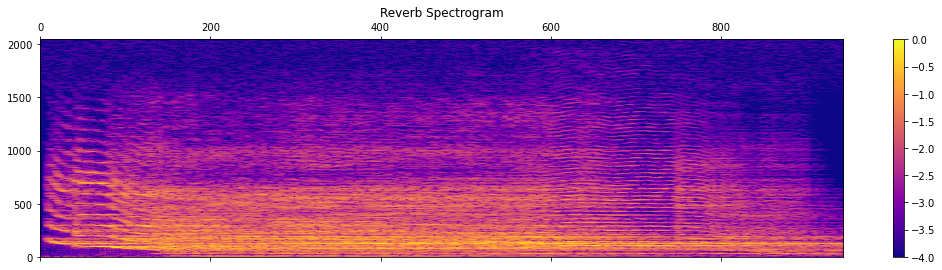

In [8]:
spec2 = pretty_spectrogram(
    data2.astype("float64"),
    fft_size=fft_size,
    step_size=step_size,
    log=True,
    thresh=spec_thresh,
)


spec2a, spec2b = np.split(spec2, 2)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 4))
cax = ax.matshow(
    np.transpose(spec2),
    interpolation="nearest",
    aspect="auto",
    cmap='plasma',
    origin="lower",
)
fig.colorbar(cax)
plt.title("Reverb Spectrogram")

In [9]:
IPython.display.Audio(data = data2, rate = rate2)

In [10]:
X = spec1a
Y = spec2a

In [11]:
# set all CFL parameters
# generic data parameters
data_info = { 'X_dims' : X.shape,
              'Y_dims' : Y.shape,
              'Y_type' : 'continuous'}
# CDE parameters
lr = 1e-4
CDE_params = { 'batch_size'  : 32,'optimizer'   : 'adam','n_epochs': 30,'verbose'     : True,
               'dense_units' : [1024, 1024, data_info['Y_dims'][1]],'activations' : ['linear', 'linear', 'linear'],
               'dropouts'    : [0.2, 0.2, 0.0],}
# clusterer parameters
x_model = KMeans(n_clusters=5, random_state=0)
y_model = KMeans(n_clusters=5, random_state=0)
cluster_params = { 'x_model' : x_model,'y_model' : y_model }

# earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
#                                        mode ="min", patience = 5, 
#                                        restore_best_weights = True)

All results from this run will be saved to results\experiment0092
opt_config not specified in input, defaulting to {}
weights_path not specified in input, defaulting to None
loss not specified in input, defaulting to mean_squared_error
show_plot not specified in input, defaulting to True
standardize not specified in input, defaulting to False
best not specified in input, defaulting to True
verbose specified but not used by this block type
Training CFL pipeline.
Epoch 1/30
12/12 [==============================] - 1s 36ms/step - loss: 12.2776 - val_loss: 5.8628
Epoch 2/30
12/12 [==============================] - 0s 27ms/step - loss: 4.6678 - val_loss: 0.9978
Epoch 3/30
12/12 [==============================] - 0s 26ms/step - loss: 1.7454 - val_loss: 0.5125
Epoch 4/30
12/12 [==============================] - 0s 26ms/step - loss: 0.9894 - val_loss: 0.3736
Epoch 5/30
12/12 [==============================] - 0s 28ms/step - loss: 0.6729 - val_loss: 0.2876
Epoch 6/30
12/12 [====================

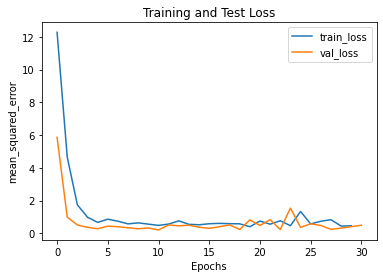

Loading parameters from  tmp_checkpoints/best_weights
Saving parameters to  results\experiment0092\trained_blocks\CondExpMod


100%|█████████████████████████████████████████████████████████████████████████████| 472/472 [00:00<00:00, 94664.16it/s]


In [12]:
block_names = ['CondExpMod', 'Clusterer']
block_params = [CDE_params, cluster_params]
save_path = 'results'

my_exp = Experiment(X_train=X, Y_train=Y, data_info=data_info, block_names=block_names, block_params=block_params, blocks=None, verbose=1, results_path=save_path,)

train_results = my_exp.train()

In [13]:
my_exp.add_dataset(X=spec1b, Y=spec2b, dataset_name='dataset_test5')

In [14]:
pred_results = my_exp.predict('dataset_test5')

100%|█████████████████████████████████████████████████████████████████████████████| 472/472 [00:00<00:00, 47324.16it/s]


*********
*********
## Flipped
[Top](#CFL-using-Reverberations)

##### Switched the Cause spectrogram and the Effect spectrogram

In [15]:
# # set all CFL parameters

# X = spec2a
# Y = spec1a
# # generic data parameters
# data_info = { 'X_dims' : X.shape,
#               'Y_dims' : Y.shape,
#               'Y_type' : 'continuous'}
# # CDE parameters
# lr = 1e-4
# CDE_params = { 'batch_size'  : 32,'optimizer'   : 'adam','n_epochs': 30,'verbose'     : True,
#                'dense_units' : [1024, 1024, data_info['Y_dims'][1]],'activations' : ['linear', 'linear', 'linear'],
#                'dropouts'    : [0.2, 0.2, 0.0],}
# # clusterer parameters
# x_model = KMeans(n_clusters=8, random_state=0)
# y_model = KMeans(n_clusters=8, random_state=0)
# cluster_params = { 'x_model' : x_model,'y_model' : y_model }

# earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
#                                         mode ="min", patience = 5, 
#                                         restore_best_weights = True)

In [16]:
# block_names = ['CondExpMod', 'Clusterer']
# block_params = [CDE_params, cluster_params]
# save_path = 'results'

# my_exp = Experiment(X_train=X, Y_train=Y, data_info=data_info, block_names=block_names, block_params=block_params, blocks=None, verbose=1, results_path=save_path,)

# train_results2 = my_exp.train()

In [17]:
# my_exp.add_dataset(X=spec2b, Y=spec1b, dataset_name='dataset_test2')
# pred_results2 = my_exp.predict('dataset_test2')

*****************
**********
## Visualized Macros
[Top](#CFL-using-Reverberations)

#### Graphed Macros

Text(0.5, 1.0, 'Spec2b: Reverb Part 2')

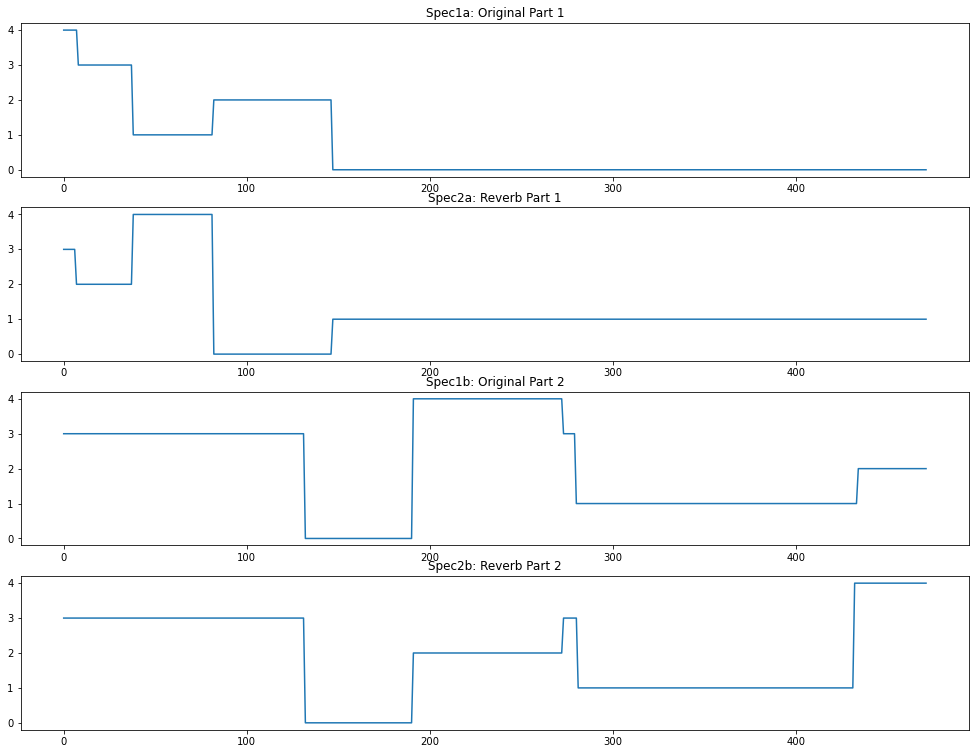

In [18]:
plt.figure(figsize = (17,13))
plt.title('Graphed Macrostates')
plt.subplot(4,1,1); plt.plot(train_results['Clusterer']['x_lbls']); plt.title('Spec1a: Original Part 1')
plt.subplot(4,1,2); plt.plot(train_results['Clusterer']['y_lbls']); plt.title('Spec2a: Reverb Part 1')
plt.subplot(4,1,3); plt.plot(pred_results['Clusterer']['x_lbls']); plt.title('Spec1b: Original Part 2')
plt.subplot(4,1,4); plt.plot(pred_results['Clusterer']['y_lbls']); plt.title('Spec2b: Reverb Part 2')

## Spectrograms for Each Macrostate
[Top](#CFL-using-Reverberations)

In [19]:
macrox0a = []
macrox1a = []
macrox2a = []
macrox3a = []
macrox4a = []
for i in range(len(train_results['Clusterer']['x_lbls'])):
    if train_results['Clusterer']['x_lbls'][i] == 0:
        macrox0a.append(i)
    elif train_results['Clusterer']['x_lbls'][i] == 1:
        macrox1a.append(i)
    elif train_results['Clusterer']['x_lbls'][i] == 2:
        macrox2a.append(i)
    elif train_results['Clusterer']['x_lbls'][i] == 3:
        macrox3a.append(i)
    else:
        macrox4a.append(i)

Text(0.5, 1.0, 'Training Cause Macro = 4')

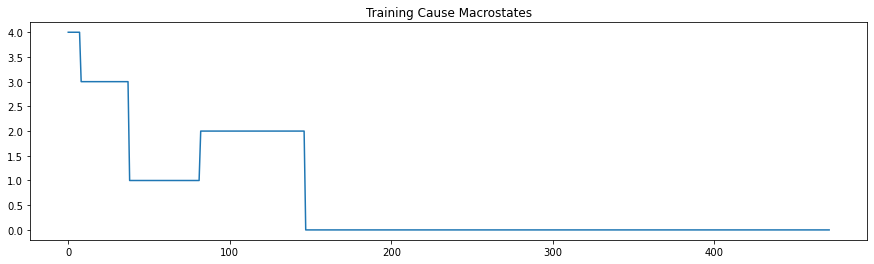

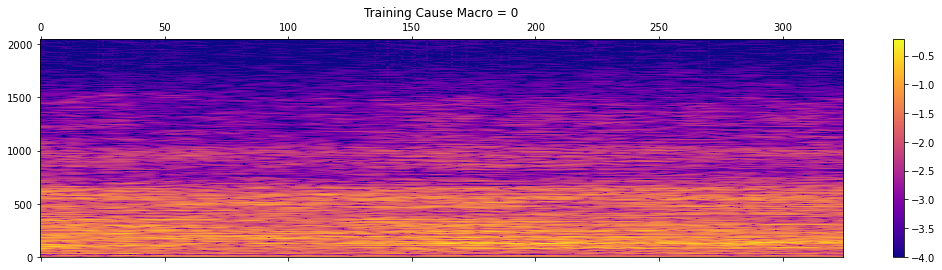

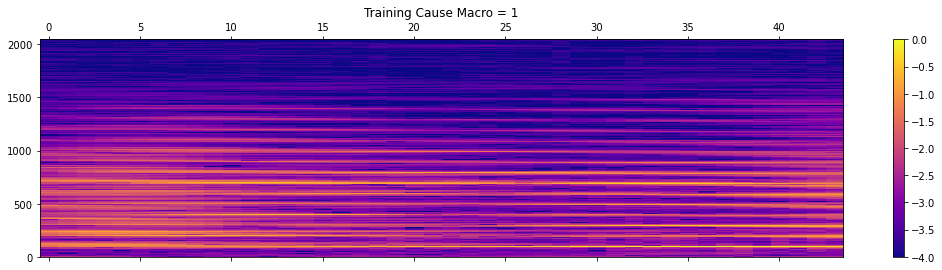

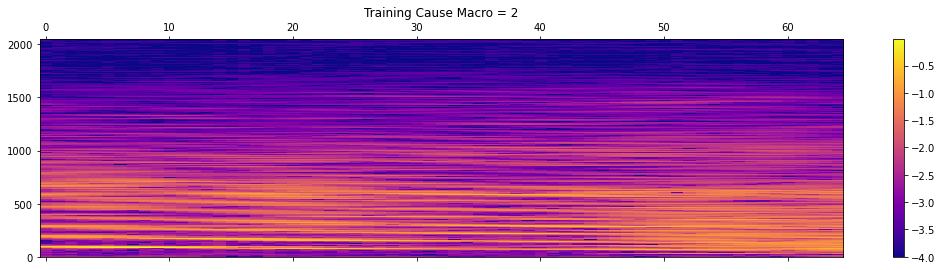

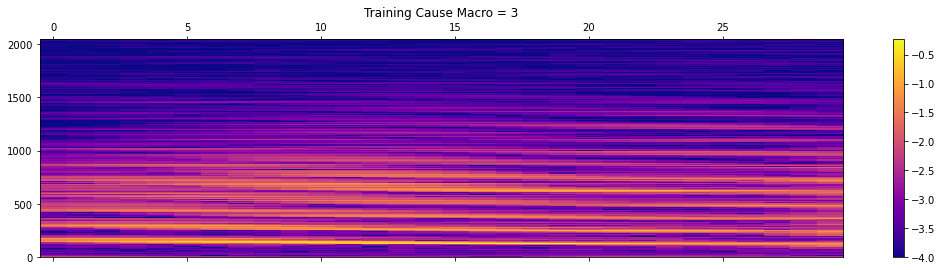

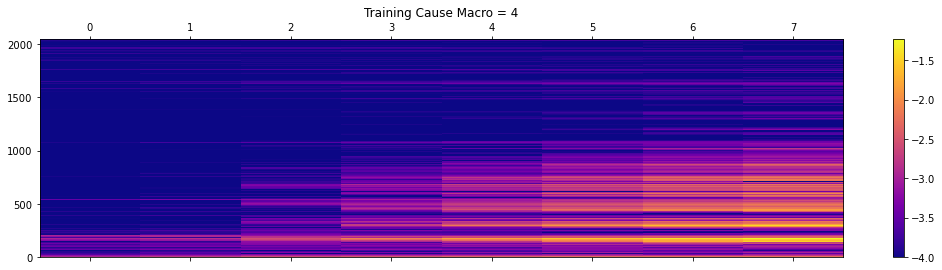

In [20]:
plt.figure(figsize = (15,4))
plt.plot(train_results['Clusterer']['x_lbls']); plt.title('Training Cause Macrostates')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 4))
cax = ax.matshow(np.transpose(spec1a[macrox0a,]),interpolation="nearest",aspect="auto",
    cmap='plasma',origin="lower",)
fig.colorbar(cax); plt.title("Training Cause Macro = 0")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 4))
cax = ax.matshow(np.transpose(spec1a[macrox1a,]),interpolation="nearest",aspect="auto",
    cmap='plasma',origin="lower",)
fig.colorbar(cax); plt.title("Training Cause Macro = 1")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 4))
cax = ax.matshow(np.transpose(spec1a[macrox2a,]),interpolation="nearest",aspect="auto",
    cmap='plasma',origin="lower",)
fig.colorbar(cax); plt.title("Training Cause Macro = 2")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 4))
cax = ax.matshow(np.transpose(spec1a[macrox3a,]),interpolation="nearest",aspect="auto",
    cmap='plasma',origin="lower",)
fig.colorbar(cax); plt.title("Training Cause Macro = 3")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 4))
cax = ax.matshow(np.transpose(spec1a[macrox4a,]),interpolation="nearest",aspect="auto",
    cmap='plasma',origin="lower",)
fig.colorbar(cax); plt.title("Training Cause Macro = 4")

In [21]:
spec1a[macrox0a,].shape

sum(spec1a[macrox0a,]).shape

(2048,)

In [22]:
macroy0a = []
macroy1a = []
macroy2a = []
macroy3a = []
macroy4a = []
for i in range(len(train_results['Clusterer']['y_lbls'])):
    if train_results['Clusterer']['y_lbls'][i] == 0:
        macroy0a.append(i)
    elif train_results['Clusterer']['y_lbls'][i] == 1:
        macroy1a.append(i)
    elif train_results['Clusterer']['y_lbls'][i] == 2:
        macroy2a.append(i)
    elif train_results['Clusterer']['y_lbls'][i] == 3:
        macroy3a.append(i)
    else:
        macroy4a.append(i)

Text(0.5, 1.0, 'Spectrogram 2a Macro = 4')

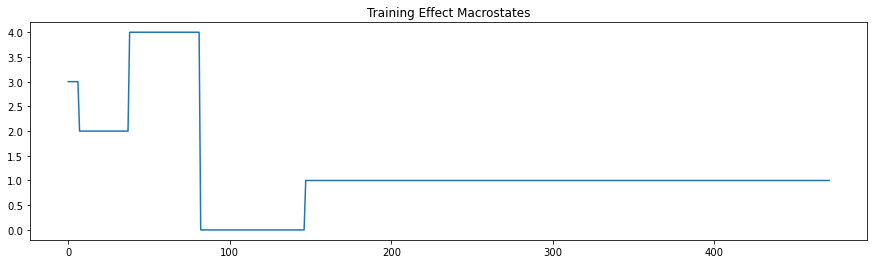

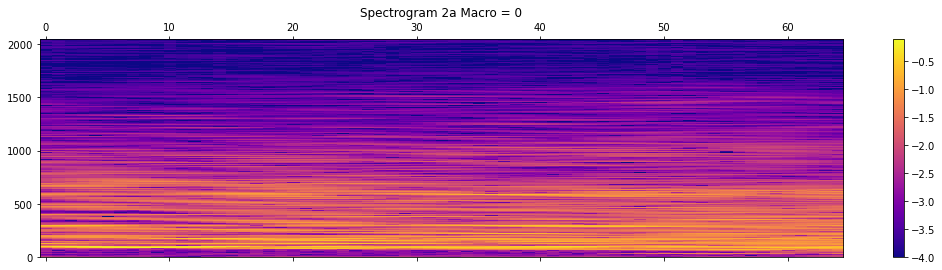

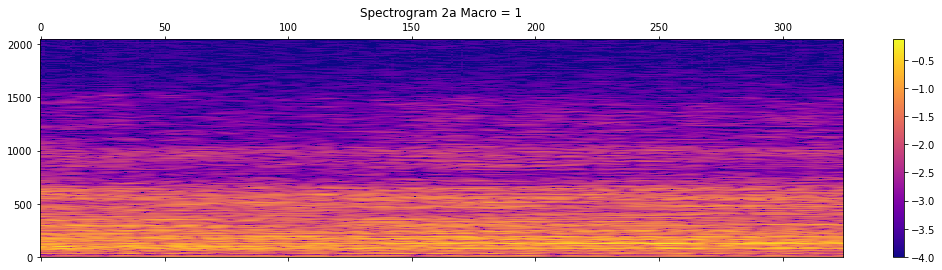

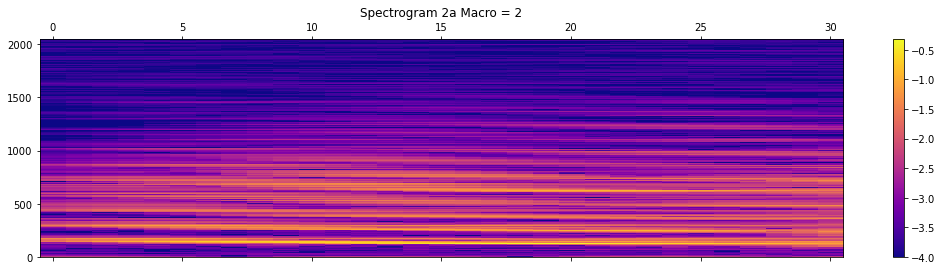

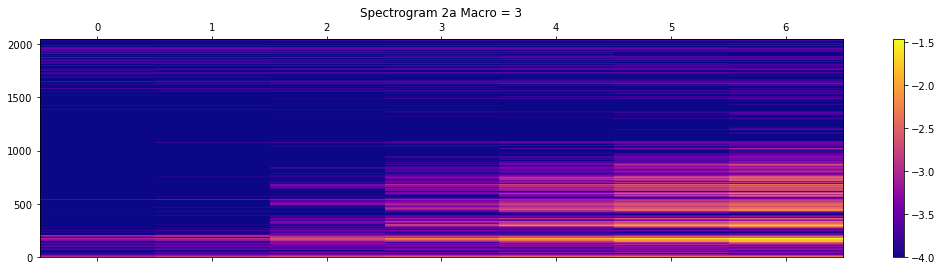

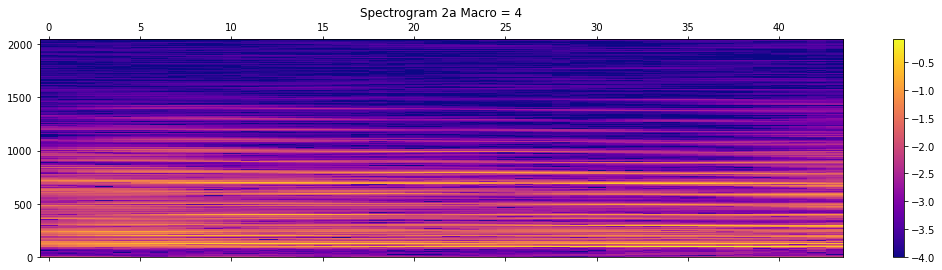

In [23]:
plt.figure(figsize = (15,4))
plt.plot(train_results['Clusterer']['y_lbls']); plt.title('Training Effect Macrostates')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 4))
cax = ax.matshow(np.transpose(spec2a[macroy0a,]),interpolation="nearest",aspect="auto",
    cmap='plasma',origin="lower",)
fig.colorbar(cax); plt.title("Spectrogram 2a Macro = 0")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 4))
cax = ax.matshow(np.transpose(spec2a[macroy1a,]),interpolation="nearest",aspect="auto",
    cmap='plasma',origin="lower",)
fig.colorbar(cax); plt.title("Spectrogram 2a Macro = 1")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 4))
cax = ax.matshow(np.transpose(spec2a[macroy2a,]),interpolation="nearest",aspect="auto",
    cmap='plasma',origin="lower",)
fig.colorbar(cax); plt.title("Spectrogram 2a Macro = 2")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 4))
cax = ax.matshow(np.transpose(spec2a[macroy3a,]),interpolation="nearest",aspect="auto",
    cmap='plasma',origin="lower",)
fig.colorbar(cax); plt.title("Spectrogram 2a Macro = 3")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 4))
cax = ax.matshow(np.transpose(spec2a[macroy4a,]),interpolation="nearest",aspect="auto",
    cmap='plasma',origin="lower",)
fig.colorbar(cax); plt.title("Spectrogram 2a Macro = 4")

In [24]:
macrox0b = []
macrox1b = []
macrox2b = []
macrox3b = []
macrox4b = []
for i in range(len(pred_results['Clusterer']['x_lbls'])):
    if pred_results['Clusterer']['x_lbls'][i] == 0:
        macrox0b.append(i)
    elif pred_results['Clusterer']['x_lbls'][i] == 1:
        macrox1b.append(i)
    elif pred_results['Clusterer']['x_lbls'][i] == 2:
        macrox2b.append(i)
    elif pred_results['Clusterer']['x_lbls'][i] == 3:
        macrox3b.append(i)
    else:
        macrox4b.append(i)

Text(0.5, 1.0, 'Spectrogram 1b Macro = 4')

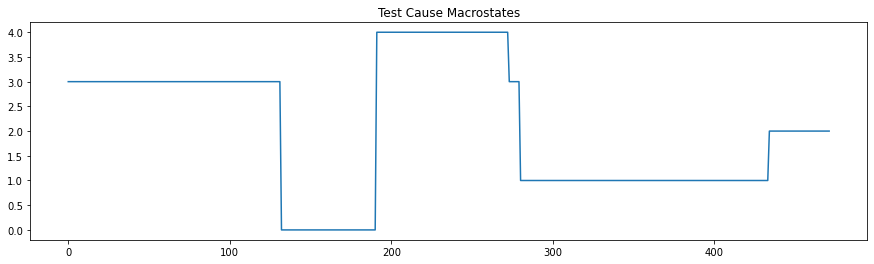

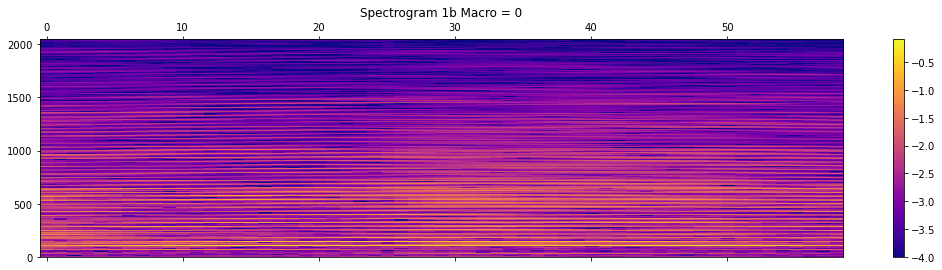

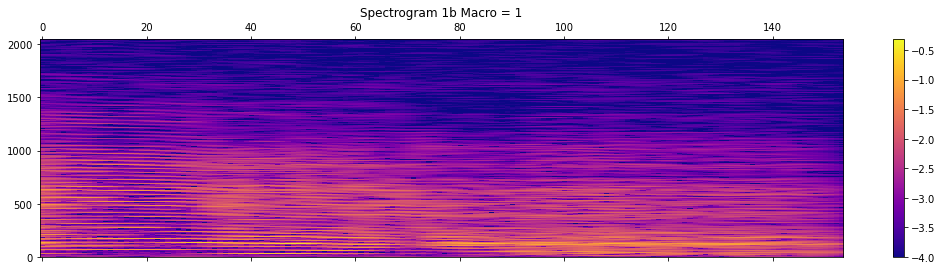

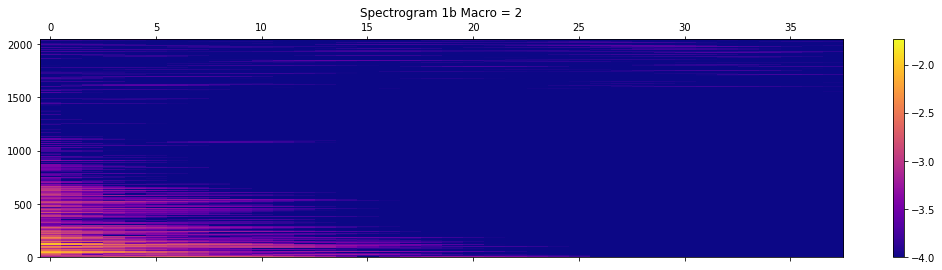

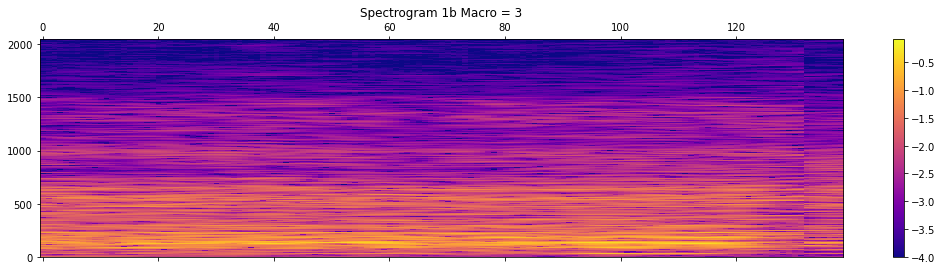

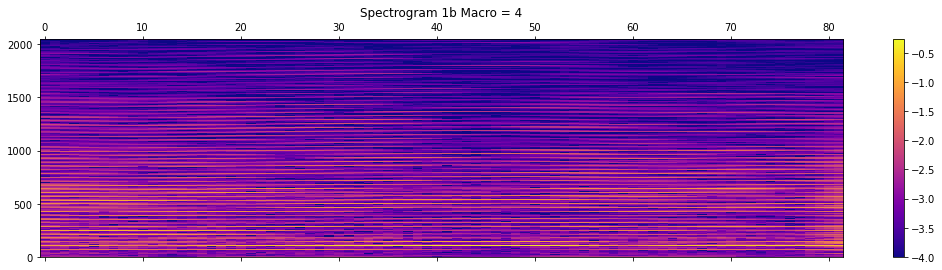

In [25]:
plt.figure(figsize = (15,4))
plt.plot(pred_results['Clusterer']['x_lbls']); plt.title('Test Cause Macrostates')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 4))
cax = ax.matshow(np.transpose(spec1b[macrox0b,]),interpolation="nearest",aspect="auto",
    cmap='plasma',origin="lower",)
fig.colorbar(cax); plt.title("Spectrogram 1b Macro = 0")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 4))
cax = ax.matshow(np.transpose(spec1b[macrox1b,]),interpolation="nearest",aspect="auto",
    cmap='plasma',origin="lower",)
fig.colorbar(cax); plt.title("Spectrogram 1b Macro = 1")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 4))
cax = ax.matshow(np.transpose(spec1b[macrox2b,]),interpolation="nearest",aspect="auto",
    cmap='plasma',origin="lower",)
fig.colorbar(cax); plt.title("Spectrogram 1b Macro = 2")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 4))
cax = ax.matshow(np.transpose(spec1b[macrox3b,]),interpolation="nearest",aspect="auto",
    cmap='plasma',origin="lower",)
fig.colorbar(cax); plt.title("Spectrogram 1b Macro = 3")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 4))
cax = ax.matshow(np.transpose(spec1b[macrox4b,]),interpolation="nearest",aspect="auto",
    cmap='plasma',origin="lower",)
fig.colorbar(cax); plt.title("Spectrogram 1b Macro = 4")

In [26]:
macroy0b = []
macroy1b = []
macroy2b = []
macroy3b = []
macroy4b = []
for i in range(len(pred_results['Clusterer']['y_lbls'])):
    if pred_results['Clusterer']['y_lbls'][i] == 0:
        macroy0b.append(i)
    elif pred_results['Clusterer']['y_lbls'][i] == 1:
        macroy1b.append(i)
    elif pred_results['Clusterer']['y_lbls'][i] == 2:
        macroy2b.append(i)
    elif pred_results['Clusterer']['y_lbls'][i] == 3:
        macroy3b.append(i)
    else:
        macroy4b.append(i)

Text(0.5, 1.0, 'Spectrogram 2b Macro = 4')

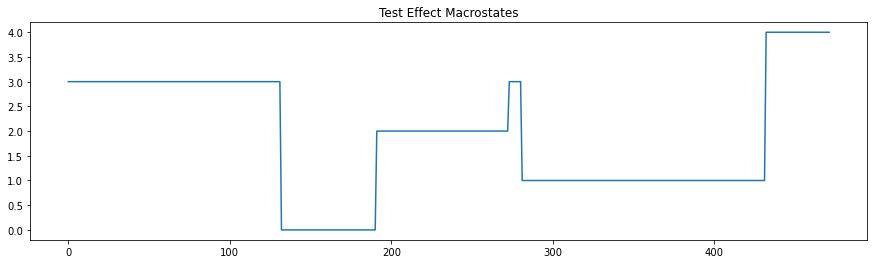

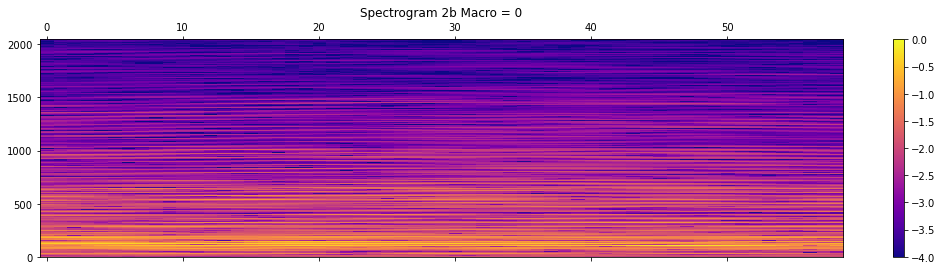

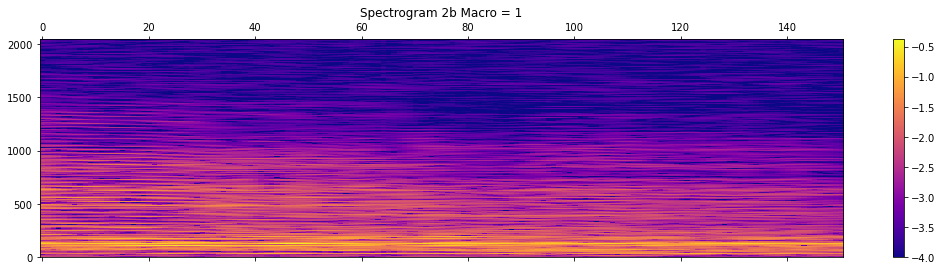

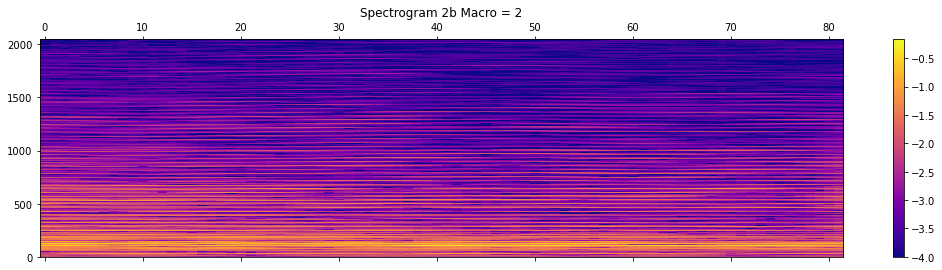

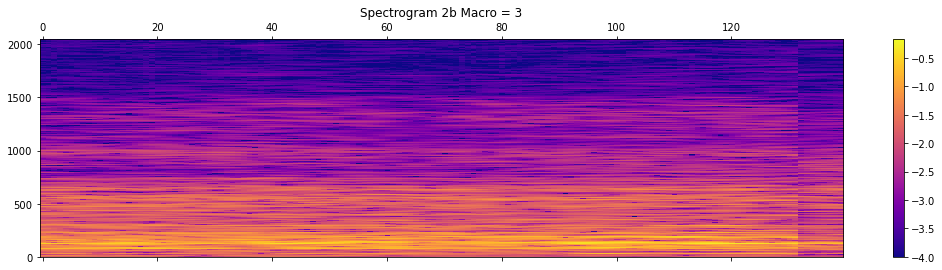

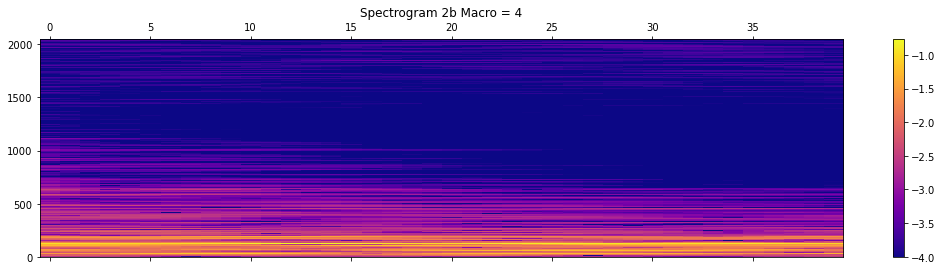

In [27]:
plt.figure(figsize = (15,4))
plt.plot(pred_results['Clusterer']['y_lbls']); plt.title('Test Effect Macrostates')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 4))
cax = ax.matshow(np.transpose(spec2b[macroy0b,]),interpolation="nearest",aspect="auto",
    cmap='plasma',origin="lower",)
fig.colorbar(cax); plt.title("Spectrogram 2b Macro = 0")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 4))
cax = ax.matshow(np.transpose(spec2b[macroy1b,]),interpolation="nearest",aspect="auto",
    cmap='plasma',origin="lower",)
fig.colorbar(cax); plt.title("Spectrogram 2b Macro = 1")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 4))
cax = ax.matshow(np.transpose(spec2b[macroy2b,]),interpolation="nearest",aspect="auto",
    cmap='plasma',origin="lower",)
fig.colorbar(cax); plt.title("Spectrogram 2b Macro = 2")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 4))
cax = ax.matshow(np.transpose(spec2b[macroy3b,]),interpolation="nearest",aspect="auto",
    cmap='plasma',origin="lower",)
fig.colorbar(cax); plt.title("Spectrogram 2b Macro = 3")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 4))
cax = ax.matshow(np.transpose(spec2b[macroy4b,]),interpolation="nearest",aspect="auto",
    cmap='plasma',origin="lower",)
fig.colorbar(cax); plt.title("Spectrogram 2b Macro = 4")

### Probability Matrix for Cause and Effect Pairings

* compute transition prob matrix for c+e pairings (0:4,0:4) w/ train
* w/ test look at e macro as f(t), ignore cause-test, take effect, use transition prob to guess cause
* for ever time point, look at every cause macro, pick rand column
* turn time series into spec 
    * for every time, take rand column from causal macro, input unti filled
    * build as spec, invert and ?see



In [28]:
############ I fully realize this is suboptimal coding, I'll work in a nested loop at some point
c0e0, c1e0, c2e0, c3e0, c4e0 = np.zeros((5,), dtype=int)
c0e1, c1e1, c2e1, c3e1, c4e1 = np.zeros((5,), dtype=int)
c0e2, c1e2, c2e2, c3e2, c4e2 = np.zeros((5,), dtype=int)
c0e3, c1e3, c2e3, c3e3, c4e3 = np.zeros((5,), dtype=int)
c0e4, c1e4, c2e4, c3e4, c4e4 = np.zeros((5,), dtype=int)

for i in range(0,len(train_results['Clusterer']['x_lbls'])):
    if train_results['Clusterer']['y_lbls'][i] == 0 and train_results['Clusterer']['x_lbls'][i] == 0:
        c0e0 += 1
    elif train_results['Clusterer']['y_lbls'][i] == 0 and train_results['Clusterer']['x_lbls'][i] == 1:
        c1e0 += 1
    elif train_results['Clusterer']['y_lbls'][i] == 0 and train_results['Clusterer']['x_lbls'][i] == 2:
        c2e0 += 1
    elif train_results['Clusterer']['y_lbls'][i] == 0 and train_results['Clusterer']['x_lbls'][i] == 3:
        c3e0 += 1
    elif train_results['Clusterer']['y_lbls'][i] == 0 and train_results['Clusterer']['x_lbls'][i] == 4:
        c4e0 += 1
    elif train_results['Clusterer']['y_lbls'][i] == 1 and train_results['Clusterer']['x_lbls'][i] == 0:
        c0e1 += 1
    elif train_results['Clusterer']['y_lbls'][i] == 1 and train_results['Clusterer']['x_lbls'][i] == 1:
        c1e1 += 1
    elif train_results['Clusterer']['y_lbls'][i] == 1 and train_results['Clusterer']['x_lbls'][i] == 2:
        c2e1 += 1
    elif train_results['Clusterer']['y_lbls'][i] == 1 and train_results['Clusterer']['x_lbls'][i] == 3:
        c3e1 += 1
    elif train_results['Clusterer']['y_lbls'][i] == 1 and train_results['Clusterer']['x_lbls'][i] == 4:
        c4e1 += 1
    elif train_results['Clusterer']['y_lbls'][i] == 2 and train_results['Clusterer']['x_lbls'][i] == 0:
        c0e2 += 1
    elif train_results['Clusterer']['y_lbls'][i] == 2 and train_results['Clusterer']['x_lbls'][i] == 1:
        c1e2 += 1
    elif train_results['Clusterer']['y_lbls'][i] == 2 and train_results['Clusterer']['x_lbls'][i] == 2:
        c2e2 += 1
    elif train_results['Clusterer']['y_lbls'][i] == 2 and train_results['Clusterer']['x_lbls'][i] == 3:
        c3e2 += 1
    elif train_results['Clusterer']['y_lbls'][i] == 2 and train_results['Clusterer']['x_lbls'][i] == 4:
        c4e2 += 1
    elif train_results['Clusterer']['y_lbls'][i] == 3 and train_results['Clusterer']['x_lbls'][i] == 0:
        c0e3 += 1
    elif train_results['Clusterer']['y_lbls'][i] == 3 and train_results['Clusterer']['x_lbls'][i] == 1:
        c1e3 += 1
    elif train_results['Clusterer']['y_lbls'][i] == 3 and train_results['Clusterer']['x_lbls'][i] == 2:
        c2e3 += 1
    elif train_results['Clusterer']['y_lbls'][i] == 3 and train_results['Clusterer']['x_lbls'][i] == 3:
        c3e3 += 1
    elif train_results['Clusterer']['y_lbls'][i] == 3 and train_results['Clusterer']['x_lbls'][i] == 4:
        c4e3 += 1
    elif train_results['Clusterer']['y_lbls'][i] == 4 and train_results['Clusterer']['x_lbls'][i] == 0:
        c0e4 += 1
    elif train_results['Clusterer']['y_lbls'][i] == 4 and train_results['Clusterer']['x_lbls'][i] == 1:
        c1e4 += 1
    elif train_results['Clusterer']['y_lbls'][i] == 4 and train_results['Clusterer']['x_lbls'][i] == 2:
        c2e4 += 1
    elif train_results['Clusterer']['y_lbls'][i] == 4 and train_results['Clusterer']['x_lbls'][i] == 3:
        c3e4 += 1
    elif train_results['Clusterer']['y_lbls'][i] == 4 and train_results['Clusterer']['x_lbls'][i] == 4:
        c4e4 += 1
        


In [29]:
tab1a = PrettyTable(['C+E Train', '0C', '1C', '2C', '3C', '4C'])
tab1a.add_row(['0E', c0e0, c1e0 ,c2e0, c3e0, c4e0])
tab1a.add_row(['1E', c0e1, c1e1, c2e1, c3e1, c4e1])
tab1a.add_row(['2E', c0e2, c1e2, c2e2, c3e2, c4e2])
tab1a.add_row(['3E', c0e3, c1e3, c2e3, c3e3, c4e3])
tab1a.add_row(['4E', c0e4, c1e4, c2e4, c3e4, c4e4])

In [30]:
############ I fully realize this is suboptimal coding, I'll work in a nested loop at some point
c0e0e, c1e0e, c2e0e, c3e0e, c4e0e = np.zeros((5,), dtype=int)
c0e1e, c1e1e, c2e1e, c3e1e, c4e1e = np.zeros((5,), dtype=int)
c0e2e, c1e2e, c2e2e, c3e2e, c4e2e = np.zeros((5,), dtype=int)
c0e3e, c1e3e, c2e3e, c3e3e, c4e3e = np.zeros((5,), dtype=int)
c0e4e, c1e4e, c2e4e, c3e4e, c4e4e = np.zeros((5,), dtype=int)

for i in range(0,len(pred_results['Clusterer']['x_lbls'])):
    if pred_results['Clusterer']['y_lbls'][i] == 0 and pred_results['Clusterer']['x_lbls'][i] == 0:
        c0e0e += 1
    elif pred_results['Clusterer']['y_lbls'][i] == 0 and pred_results['Clusterer']['x_lbls'][i] == 1:
        c1e0e += 1
    elif pred_results['Clusterer']['y_lbls'][i] == 0 and pred_results['Clusterer']['x_lbls'][i] == 2:
        c2e0e += 1
    elif pred_results['Clusterer']['y_lbls'][i] == 0 and pred_results['Clusterer']['x_lbls'][i] == 3:
        c3e0e += 1
    elif pred_results['Clusterer']['y_lbls'][i] == 0 and pred_results['Clusterer']['x_lbls'][i] == 4:
        c4e0e += 1
    elif pred_results['Clusterer']['y_lbls'][i] == 1 and pred_results['Clusterer']['x_lbls'][i] == 0:
        c0e1e += 1
    elif pred_results['Clusterer']['y_lbls'][i] == 1 and pred_results['Clusterer']['x_lbls'][i] == 1:
        c1e1e += 1
    elif pred_results['Clusterer']['y_lbls'][i] == 1 and pred_results['Clusterer']['x_lbls'][i] == 2:
        c2e1e += 1
    elif pred_results['Clusterer']['y_lbls'][i] == 1 and pred_results['Clusterer']['x_lbls'][i] == 3:
        c3e1e += 1
    elif pred_results['Clusterer']['y_lbls'][i] == 1 and pred_results['Clusterer']['x_lbls'][i] == 4:
        c4e1e += 1
    elif pred_results['Clusterer']['y_lbls'][i] == 2 and pred_results['Clusterer']['x_lbls'][i] == 0:
        c0e2e += 1
    elif pred_results['Clusterer']['y_lbls'][i] == 2 and pred_results['Clusterer']['x_lbls'][i] == 1:
        c1e2e += 1
    elif pred_results['Clusterer']['y_lbls'][i] == 2 and pred_results['Clusterer']['x_lbls'][i] == 2:
        c2e2e += 1
    elif pred_results['Clusterer']['y_lbls'][i] == 2 and pred_results['Clusterer']['x_lbls'][i] == 3:
        c3e2e += 1
    elif pred_results['Clusterer']['y_lbls'][i] == 2 and pred_results['Clusterer']['x_lbls'][i] == 4:
        c4e2e += 1
    elif pred_results['Clusterer']['y_lbls'][i] == 3 and pred_results['Clusterer']['x_lbls'][i] == 0:
        c0e3e += 1
    elif pred_results['Clusterer']['y_lbls'][i] == 3 and pred_results['Clusterer']['x_lbls'][i] == 1:
        c1e3e += 1
    elif pred_results['Clusterer']['y_lbls'][i] == 3 and pred_results['Clusterer']['x_lbls'][i] == 2:
        c2e3e += 1
    elif pred_results['Clusterer']['y_lbls'][i] == 3 and pred_results['Clusterer']['x_lbls'][i] == 3:
        c3e3e += 1
    elif pred_results['Clusterer']['y_lbls'][i] == 3 and pred_results['Clusterer']['x_lbls'][i] == 4:
        c4e3e += 1
    elif pred_results['Clusterer']['y_lbls'][i] == 4 and pred_results['Clusterer']['x_lbls'][i] == 0:
        c0e4e += 1
    elif pred_results['Clusterer']['y_lbls'][i] == 4 and pred_results['Clusterer']['x_lbls'][i] == 1:
        c1e4e += 1
    elif pred_results['Clusterer']['y_lbls'][i] == 4 and pred_results['Clusterer']['x_lbls'][i] == 2:
        c2e4e += 1
    elif pred_results['Clusterer']['y_lbls'][i] == 4 and pred_results['Clusterer']['x_lbls'][i] == 3:
        c3e4e += 1
    elif pred_results['Clusterer']['y_lbls'][i] == 4 and pred_results['Clusterer']['x_lbls'][i] == 4:
        c4e4e += 1
        
tab2a = PrettyTable(['C+E Test', '0C', '1C', '2C', '3C', '4C'])
tab2a.add_row(['0E', c0e0e, c1e0e ,c2e0e, c3e0e, c4e0e])
tab2a.add_row(['1E', c0e1e, c1e1e, c2e1e, c3e1e, c4e1e])
tab2a.add_row(['2E', c0e2e, c1e2e, c2e2e, c3e2e, c4e2e])
tab2a.add_row(['3E', c0e3e, c1e3e, c2e3e, c3e3e, c4e3e])
tab2a.add_row(['4E', c0e4e, c1e4e, c2e4e, c3e4e, c4e4e])

In [31]:
print(tab1a,'\n',tab2a)

+-----------+-----+----+----+----+----+
| C+E Train |  0C | 1C | 2C | 3C | 4C |
+-----------+-----+----+----+----+----+
|     0E    |  0  | 0  | 65 | 0  | 0  |
|     1E    | 325 | 0  | 0  | 0  | 0  |
|     2E    |  0  | 0  | 0  | 30 | 1  |
|     3E    |  0  | 0  | 0  | 0  | 7  |
|     4E    |  0  | 44 | 0  | 0  | 0  |
+-----------+-----+----+----+----+----+ 
 +----------+----+-----+----+-----+----+
| C+E Test | 0C |  1C | 2C |  3C | 4C |
+----------+----+-----+----+-----+----+
|    0E    | 59 |  0  | 0  |  0  | 0  |
|    1E    | 0  | 151 | 0  |  0  | 0  |
|    2E    | 0  |  0  | 0  |  0  | 82 |
|    3E    | 0  |  1  | 0  | 139 | 0  |
|    4E    | 0  |  2  | 38 |  0  | 0  |
+----------+----+-----+----+-----+----+


## Prediction from Macrostates
[TOP](#CFL-using-Reverberations)

In [32]:
# average train causes 
ave1a_m0 = sum(spec1a[macrox0a,]) / spec1a[macrox0a,].shape[0]
ave1a_m1 = sum(spec1a[macrox1a,]) / spec1a[macrox1a,].shape[0]
ave1a_m2 = sum(spec1a[macrox2a,]) / spec1a[macrox2a,].shape[0]
ave1a_m3 = sum(spec1a[macrox3a,]) / spec1a[macrox3a,].shape[0]
ave1a_m4 = sum(spec1a[macrox4a,]) / spec1a[macrox4a,].shape[0]

In [33]:
# average train effects
ave2a_m0 = sum(spec2a[macroy0a,]) / spec2a[macroy0a,].shape[0]
ave2a_m1 = sum(spec2a[macroy1a,]) / spec2a[macroy1a,].shape[0]
ave2a_m2 = sum(spec2a[macroy2a,]) / spec2a[macroy2a,].shape[0]
ave2a_m3 = sum(spec2a[macroy3a,]) / spec2a[macroy3a,].shape[0]
ave2a_m4 = sum(spec2a[macroy4a,]) / spec2a[macroy4a,].shape[0]
aveEffect = [ave2a_m0, ave2a_m1, ave2a_m2, ave2a_m3, ave2a_m4]

In [34]:
# automate linkage between cause macrostates and effect macrostates


# check max effect macrostate within each cause macrostate
maxed0 = max(c0e0, c0e1, c0e2, c0e3, c0e4)
maxed1 = max(c1e0, c1e1, c1e2, c1e3, c1e4)
maxed2 = max(c2e0, c2e1, c2e2, c2e3, c2e4)
maxed3 = max(c3e0, c3e1, c3e2, c3e3, c3e4)
maxed4 = max(c4e0, c4e1, c4e2, c4e3, c4e4)

# creating lists of each macrostate to check through
max0, max1, max2, max3, max4 = np.zeros((5,), dtype = int)
maxe0 = [c0e0, c0e1, c0e2, c0e3, c0e4]
maxe1 = [c1e0, c1e1, c1e2, c1e3, c1e4]
maxe2 = [c2e0, c2e1, c2e2, c2e3, c2e4]
maxe3 = [c3e0, c3e1, c3e2, c3e3, c3e4]
maxe4 = [c4e0, c4e1, c4e2, c4e3, c4e4]


# checks to see which effect macrostate is maxed for each cause macrostate and stores it
for i in range(0,5): 
    if maxe0[i] == maxed0:
        max0 = i 
for i in range(0,5):
    if maxe1[i] == maxed1:
        max1 = i
for i in range(0,5):
    if maxe2[i] == maxed2:
        max2 = i
for i in range(0,5):
    if maxe3[i] == maxed3:
        max3 = i
for i in range(0,5):
    if maxe4[i] == maxed4:
        max4 = i

print(max0, max1, max2, max3, max4)


# creating list of the spectrograms made up of each training effect macrostate 
yspeclist = [spec2a[macroy0a,],spec2a[macroy1a,],spec2a[macroy2a,],spec2a[macroy3a],spec2a[macroy4a]]

1 4 0 2 3


In [35]:
# for each slice in test cause, compare to the average train cause

finalRand = np.ndarray((spec1b.shape[0], spec1b.shape[1]))
finalAve =  np.ndarray((spec1b.shape[0], spec1b.shape[1]))

for i in range(0,len(spec1b)):

    # checking how similar each slice of test cause is to training cause
    zerom = sum( (spec1b[i] - ave1a_m0)**2 ) 
    onem = sum( (spec1b[i] - ave1a_m1)**2 )
    twom = sum( (spec1b[i] - ave1a_m2)**2 )
    threem = sum( (spec1b[i] - ave1a_m3)**2 )
    fourm = sum( (spec1b[i] - ave1a_m4)**2 )

    lis = (zerom, onem, twom, threem, fourm)

    # finds smallest value, meaning most similar
    if (min(lis) == zerom):
        minmacro = 0
    elif (min(lis) == onem):
        minmacro = 1
    elif (min(lis) == twom):
        minmacro = 2
    elif (min(lis) == threem):
        minmacro = 3
    elif (min(lis) == fourm):
        minmacro = 4


    # take minmacro, and get the connected training effect macrostate
    # use the average value from the training effect as predicted effect

    # using average values
    if minmacro == 0:
        finalAve[i] = aveEffect[max0]
    elif minmacro == 1:
        finalAve[i] = aveEffect[max1]
    elif minmacro == 2:
        finalAve[i] = aveEffect[max2]
    elif minmacro == 3:
        finalAve[i] = aveEffect[max3]
    elif minmacro == 4:
        finalAve[i] = aveEffect[max4]

    # using random slices from the relevant training effect macrostate
    if minmacro == 0:
        finalRand[i] = yspeclist[max0][randrange(0,yspeclist[max0].shape[0])]
    elif minmacro == 1:
        finalRand[i] = yspeclist[max1][randrange(0,yspeclist[max1].shape[0])]
    elif minmacro == 2:
        finalRand[i] = yspeclist[max2][randrange(0,yspeclist[max2].shape[0])]
    elif minmacro == 3:
        finalRand[i] = yspeclist[max3][randrange(0,yspeclist[max3].shape[0])]
    elif minmacro == 4:
        finalRand[i] = yspeclist[max4][randrange(0,yspeclist[max4].shape[0])]


# spec1b.shape = (472, 2048)


Text(0.5, 1.0, 'Actual Test Effect')

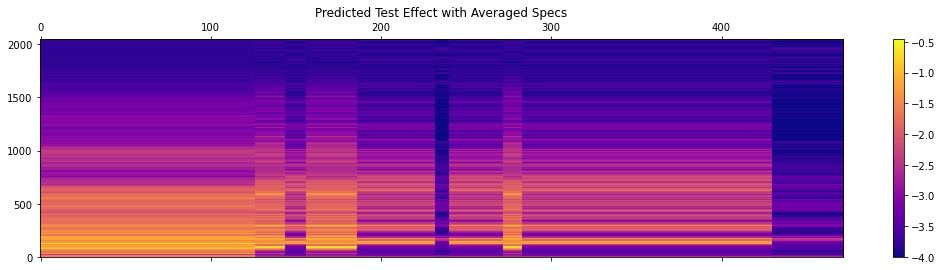

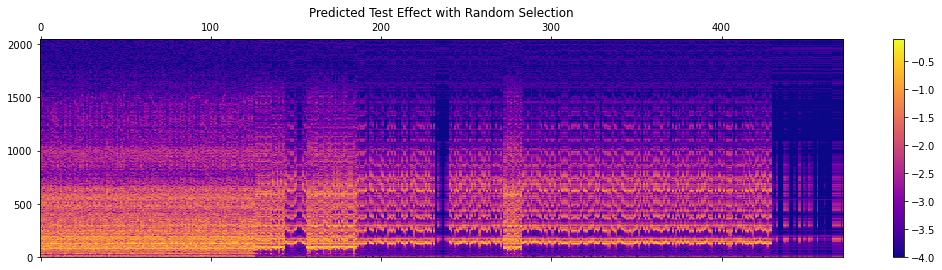

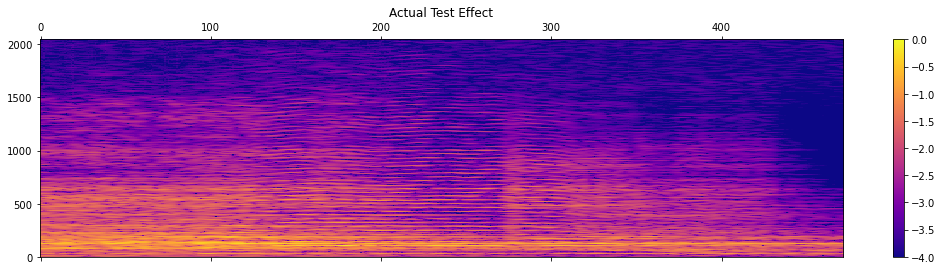

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 4))
cax = ax.matshow(np.transpose(finalAve),interpolation="nearest",aspect="auto",
    cmap='plasma',origin="lower",
)
fig.colorbar(cax)
plt.title("Predicted Test Effect with Averaged Specs")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 4))
cax = ax.matshow(np.transpose(finalRand),interpolation="nearest",aspect="auto",
    cmap='plasma',origin="lower",
)
fig.colorbar(cax)
plt.title("Predicted Test Effect with Random Selection")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 4))
cax = ax.matshow(np.transpose(spec2b),interpolation="nearest",aspect="auto",
    cmap='plasma',origin="lower",
)
fig.colorbar(cax)
plt.title("Actual Test Effect")

In [37]:
# inverted spec of predicted effect Average
invertpredAve = invert_pretty_spectrogram(
    finalAve, fft_size=fft_size, step_size=step_size, log=True, n_iter=10
)
IPython.display.Audio(data=invertpredAve, rate=rate) 

In [38]:
# inverted spec of predicted effect Random
invertpredRand = invert_pretty_spectrogram(
    finalRand, fft_size=fft_size, step_size=step_size, log=True, n_iter=10
)
IPython.display.Audio(data=invertpredRand, rate=rate) 

In [39]:
# inverted spec of actual effect
invertorig = invert_pretty_spectrogram(
    spec2b, fft_size=fft_size, step_size=step_size, log=True, n_iter=10
)
IPython.display.Audio(data=invertorig, rate=rate)

# Reshape

##### *haven't been able to change enough for it to accept a 3rd dim*

(472, 2048)
(470, 2048)
(2048, 10, 47)
If the lower plots are segments of the upper plot we should be good


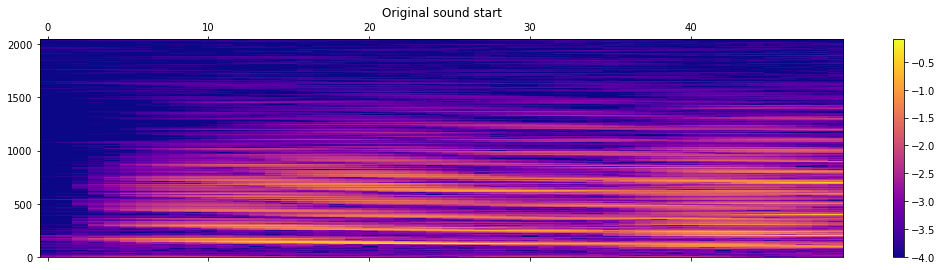

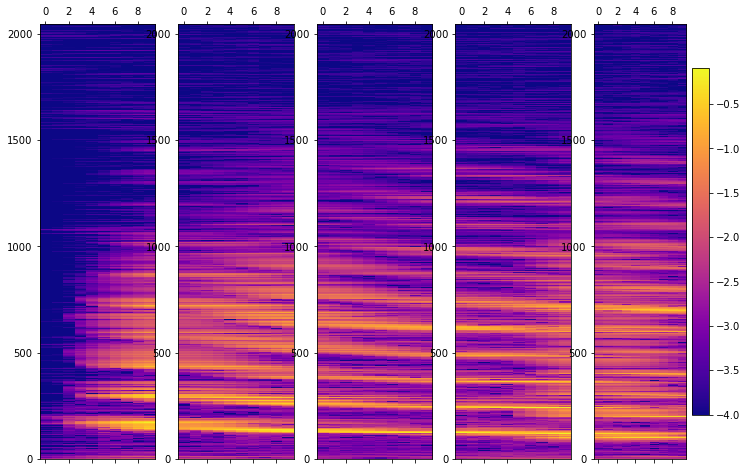

In [40]:
# First let us do this once very carefully
# There is much bookkeeping to be done with reshaping
# We should plot everything to make sure the re-shaping is correct

orig_sound_start = spec1a
print(np.shape(orig_sound_start))

trim_orig_sound_start = orig_sound_start[0:470,:]
print(np.shape(trim_orig_sound_start))

reshaped_orig_sound_start = np.reshape(np.transpose(trim_orig_sound_start), [2048,10,47], order='F')
print(np.shape(reshaped_orig_sound_start))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 4))
cax = ax.matshow(np.transpose(trim_orig_sound_start[0:50,:]),interpolation="nearest",aspect="auto",
    cmap='plasma',origin="lower",
)
fig.colorbar(cax)
plt.title("Original sound start")

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(12, 8))
for x, jax in enumerate(ax):
    cax = ax[x].matshow((reshaped_orig_sound_start[:,:,x]),interpolation="nearest",aspect="auto",
    cmap='plasma',origin="lower",
    )
fig.colorbar(cax)

print("If the lower plots are segments of the upper plot we should be good")


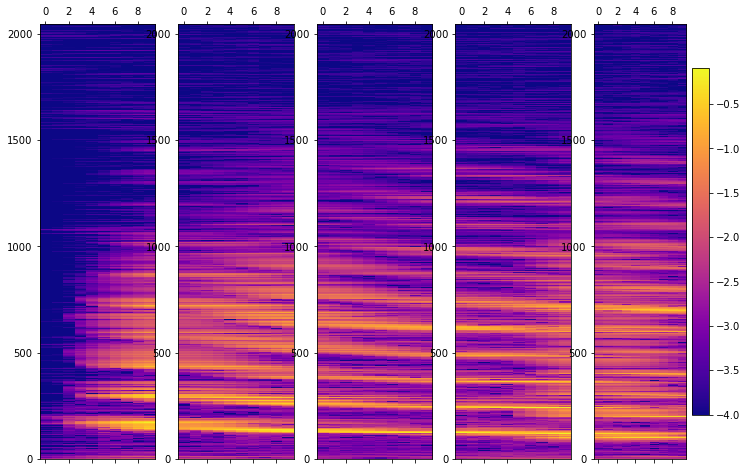

In [41]:
# Now that everything is tested, do it again in a loop
# on all the important spectrograms
# the plots should look the same as the above cell

specs = {"0": spec1a[:470,:], 
     "1": spec1b[:470,:], 
     "2": spec2a[:470,:], 
     "3": spec2b[:470,:]
        }

reshaped_specs = specs.copy()

for jj in range(4):
    reshaped_specs[str(jj)] = np.reshape(np.transpose(specs[str(jj)]), [2048,10,47], order='F')

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(12, 8))
for x, jax in enumerate(ax):
    cax = ax[x].matshow((reshaped_specs["0"][:,:,x]),interpolation="nearest",aspect="auto",
    cmap='plasma',origin="lower",
    )
fig.colorbar(cax)
    

In [130]:
## Now we run CFL on the reshaped data 

X = reshaped_specs["0"][:,:,:] # original sound
Y = reshaped_specs["2"][:,:,:] # and the reverberant version

# CFL wants a 2D matrix samples x features so now we must 
# re-arrange our data as such

shaped_X = np.reshape(X, (np.shape(X)[0]*np.shape(X)[1],np.shape(X)[2]), order = 'F')
shaped_X = np.transpose(shaped_X)

shaped_Y = np.reshape(Y, (np.shape(X)[0]*np.shape(X)[1],np.shape(X)[2]), order = 'F')
shaped_Y = np.transpose(shaped_Y)

print(np.where(np.isnan(shaped_X)))
print(np.where(np.isnan(shaped_Y)))

print(np.shape(X))
print(np.shape(Y))

print(np.shape(shaped_X))
print(np.shape(shaped_Y))


# set all CFL parameters
# generic data parameters
data_info = { 'X_dims' : shaped_X.shape,
              'Y_dims' : shaped_Y.shape,
              'Y_type' : 'continuous'}


# CDE parameters -- I am not at all sure what these values should be.... The "data_info['Y_dims'][1]" 
# seems to be a particular source of trouble
lr = 1e-4
CDE_params = { 'batch_size'  : 10,'optimizer'   : 'adam','n_epochs': 30,'verbose'     : True,
               'dense_units' : [2048, 2048, data_info['Y_dims'][1]],'activations' : ['linear', 'linear', 'linear'],
               'dropouts'    : [0.2, 0.2, 0.0],}
# clusterer parameters
x_model = KMeans(n_clusters=5, random_state=0)
y_model = KMeans(n_clusters=5, random_state=0)
cluster_params = { 'x_model' : x_model,'y_model' : y_model }

# earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
#                                        mode ="min", patience = 5, 
#                                        restore_best_weights = True)

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(2048, 10, 47)
(2048, 10, 47)
(47, 20480)
(47, 20480)


All results from this run will be saved to results\experiment0103
opt_config not specified in input, defaulting to {}
weights_path not specified in input, defaulting to None
loss not specified in input, defaulting to mean_squared_error
show_plot not specified in input, defaulting to True
standardize not specified in input, defaulting to False
best not specified in input, defaulting to True
verbose specified but not used by this block type
Training CFL pipeline.
Epoch 1/30
4/4 [==============================] - 2s 295ms/step - loss: 10768.5186 - val_loss: 531.9382
Epoch 2/30
4/4 [==============================] - 1s 271ms/step - loss: 3880.7981 - val_loss: 266.4922
Epoch 3/30
4/4 [==============================] - 1s 268ms/step - loss: 8849.2324 - val_loss: 11855.1445
Epoch 4/30
4/4 [==============================] - 1s 256ms/step - loss: 6506.9482 - val_loss: 960.4031
Epoch 5/30
4/4 [==============================] - 1s 262ms/step - loss: 2053.0435 - val_loss: 537.2606
Epoch 6/30
4/4 [

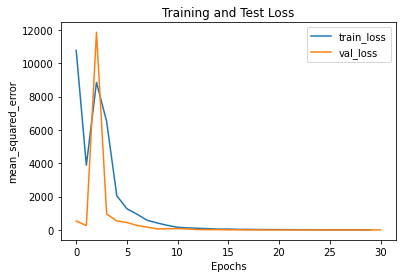

Loading parameters from  tmp_checkpoints/best_weights
Saving parameters to  results\experiment0103\trained_blocks\CondExpMod


100%|███████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 47138.28it/s]


In [131]:
# this block keeps throwing errors: could not broadcast input array from shape (47,3) into shape (47,4)

block_names = ['CondExpMod', 'Clusterer']
block_params = [CDE_params, cluster_params]
save_path = 'results'

my_expRE = Experiment(X_train=shaped_X, Y_train=shaped_Y, data_info=data_info, block_names=block_names, block_params=block_params, blocks=None, verbose=1, results_path=save_path,)

train_resultsRE = my_expRE.train()

{'x_lbls': array([2, 4, 4, 4, 1, 1, 1, 1, 4, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3,
       0, 0, 0]), 'y_lbls': array([2, 1, 1, 1, 3, 3, 3, 3, 3, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4,
       0, 0, 0])}
[13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 44, 45, 46]


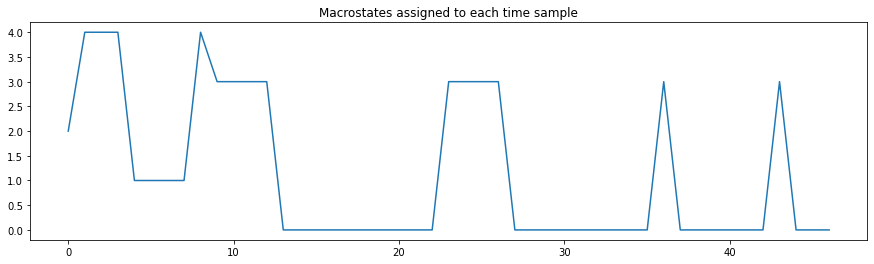

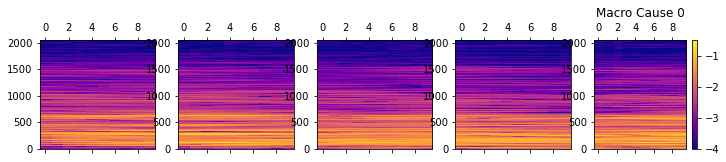

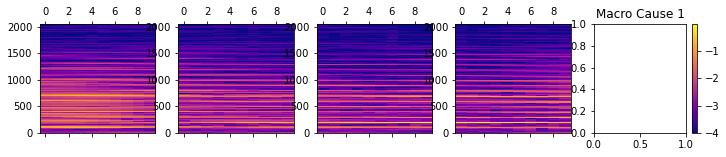

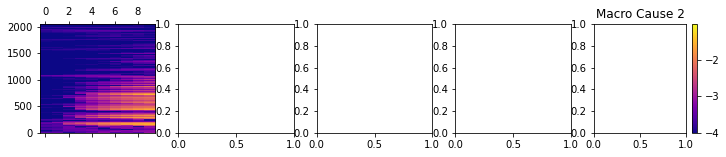

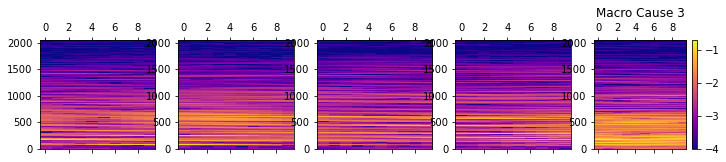

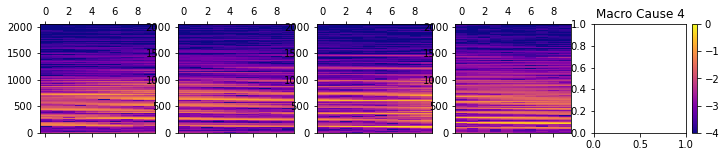

In [132]:
# here are the first matrix macro-states!!

plt.figure(figsize = (15,4))
plt.plot(train_resultsRE['Clusterer']['x_lbls']); plt.title('Train Cause Macrostates')
plt.title("Macrostates assigned to each time sample")

macro_cause_index = {"0": [], "1": [], "2": [], "3": [], "4": []}

for i in range(len(train_resultsRE['Clusterer']['x_lbls'])):
    macro_cause_index[str(train_resultsRE['Clusterer']['x_lbls'][i])].append(i)
    
print(train_resultsRE['Clusterer'])
print(macro_cause_index["0"])
    
for j in range(len(macro_cause_index)):
    # all we need from CFL is the time indices of each macrostate assignment.  We access the original data from 
    # `X` which has a human readable shape, whereas, `shaped_X` had a CFL interpretable shape 
    # print("should be indeces ", macro_cause_index[str(j)])
    MX = X[:,:,macro_cause_index[str(j)]] 
    # print(MX)
    
    fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(12, 2))
    for jj, jax in enumerate(ax):
        # print(jax)
        # print(jj)
        # print(np.shape(MX))
        # print(np.shape(MX[:,:,jj]))
        if np.shape(MX)[2] > 0: 
            if jj < np.shape(MX)[2]:
                cax = ax[jj].matshow(MX[:,:,jj],
                                     interpolation="nearest",aspect="auto",
                                     cmap='plasma',origin="lower",)
    
    fig.colorbar(cax); plt.title("Macro Cause %d" %j)
    

In [133]:
############ I fully realize this is suboptimal coding, I'll work in a nested loop at some point
REc0e0, REc1e0, REc2e0, REc3e0, REc4e0 = np.zeros((5,), dtype=int)
REc0e1, REc1e1, REc2e1, REc3e1, REc4e1 = np.zeros((5,), dtype=int)
REc0e2, REc1e2, REc2e2, REc3e2, REc4e2 = np.zeros((5,), dtype=int)
REc0e3, REc1e3, REc2e3, REc3e3, REc4e3 = np.zeros((5,), dtype=int)
REc0e4, REc1e4, REc2e4, REc3e4, REc4e4 = np.zeros((5,), dtype=int)

for i in range(0,len(train_resultsRE['Clusterer']['x_lbls'])):
    if train_resultsRE['Clusterer']['y_lbls'][i] == 0 and train_resultsRE['Clusterer']['x_lbls'][i] == 0:
        REc0e0 += 1
    elif train_resultsRE['Clusterer']['y_lbls'][i] == 0 and train_resultsRE['Clusterer']['x_lbls'][i] == 1:
        REc1e0 += 1
    elif train_resultsRE['Clusterer']['y_lbls'][i] == 0 and train_resultsRE['Clusterer']['x_lbls'][i] == 2:
        REc2e0 += 1
    elif train_resultsRE['Clusterer']['y_lbls'][i] == 0 and train_resultsRE['Clusterer']['x_lbls'][i] == 3:
        REc3e0 += 1
    elif train_resultsRE['Clusterer']['y_lbls'][i] == 0 and train_resultsRE['Clusterer']['x_lbls'][i] == 4:
        REc4e0 += 1
    elif train_resultsRE['Clusterer']['y_lbls'][i] == 1 and train_resultsRE['Clusterer']['x_lbls'][i] == 0:
        REc0e1 += 1
    elif train_resultsRE['Clusterer']['y_lbls'][i] == 1 and train_resultsRE['Clusterer']['x_lbls'][i] == 1:
        REc1e1 += 1
    elif train_resultsRE['Clusterer']['y_lbls'][i] == 1 and train_resultsRE['Clusterer']['x_lbls'][i] == 2:
        REc2e1 += 1
    elif train_resultsRE['Clusterer']['y_lbls'][i] == 1 and train_resultsRE['Clusterer']['x_lbls'][i] == 3:
        REc3e1 += 1
    elif train_resultsRE['Clusterer']['y_lbls'][i] == 1 and train_resultsRE['Clusterer']['x_lbls'][i] == 4:
        REc4e1 += 1
    elif train_resultsRE['Clusterer']['y_lbls'][i] == 2 and train_resultsRE['Clusterer']['x_lbls'][i] == 0:
        REc0e2 += 1
    elif train_resultsRE['Clusterer']['y_lbls'][i] == 2 and train_resultsRE['Clusterer']['x_lbls'][i] == 1:
        REc1e2 += 1
    elif train_resultsRE['Clusterer']['y_lbls'][i] == 2 and train_resultsRE['Clusterer']['x_lbls'][i] == 2:
        REc2e2 += 1
    elif train_resultsRE['Clusterer']['y_lbls'][i] == 2 and train_resultsRE['Clusterer']['x_lbls'][i] == 3:
        REc3e2 += 1
    elif train_resultsRE['Clusterer']['y_lbls'][i] == 2 and train_resultsRE['Clusterer']['x_lbls'][i] == 4:
        REc4e2 += 1
    elif train_resultsRE['Clusterer']['y_lbls'][i] == 3 and train_resultsRE['Clusterer']['x_lbls'][i] == 0:
        REc0e3 += 1
    elif train_resultsRE['Clusterer']['y_lbls'][i] == 3 and train_resultsRE['Clusterer']['x_lbls'][i] == 1:
        REc1e3 += 1
    elif train_resultsRE['Clusterer']['y_lbls'][i] == 3 and train_resultsRE['Clusterer']['x_lbls'][i] == 2:
        REc2e3 += 1
    elif train_resultsRE['Clusterer']['y_lbls'][i] == 3 and train_resultsRE['Clusterer']['x_lbls'][i] == 3:
        REc3e3 += 1
    elif train_resultsRE['Clusterer']['y_lbls'][i] == 3 and train_resultsRE['Clusterer']['x_lbls'][i] == 4:
        REc4e3 += 1
    elif train_resultsRE['Clusterer']['y_lbls'][i] == 4 and train_resultsRE['Clusterer']['x_lbls'][i] == 0:
        REc0e4 += 1
    elif train_resultsRE['Clusterer']['y_lbls'][i] == 4 and train_resultsRE['Clusterer']['x_lbls'][i] == 1:
        REc1e4 += 1
    elif train_resultsRE['Clusterer']['y_lbls'][i] == 4 and train_resultsRE['Clusterer']['x_lbls'][i] == 2:
        REc2e4 += 1
    elif train_resultsRE['Clusterer']['y_lbls'][i] == 4 and train_resultsRE['Clusterer']['x_lbls'][i] == 3:
        REc3e4 += 1
    elif train_resultsRE['Clusterer']['y_lbls'][i] == 4 and train_resultsRE['Clusterer']['x_lbls'][i] == 4:
        REc4e4 += 1
        


In [134]:
tab1aRE = PrettyTable(['RE C+E Train', '0C', '1C', '2C', '3C', '4C'])
tab1aRE.add_row(['0E', REc0e0, REc1e0 ,REc2e0, REc3e0, REc4e0])
tab1aRE.add_row(['1E', REc0e1, REc1e1, REc2e1, REc3e1, REc4e1])
tab1aRE.add_row(['2E', REc0e2, REc1e2, REc2e2, REc3e2, REc4e2])
tab1aRE.add_row(['3E', REc0e3, REc1e3, REc2e3, REc3e3, REc4e3])
tab1aRE.add_row(['4E', REc0e4, REc1e4, REc2e4, REc3e4, REc4e4])

Text(0.5, 1.0, 'Training Cause Macro = 4')

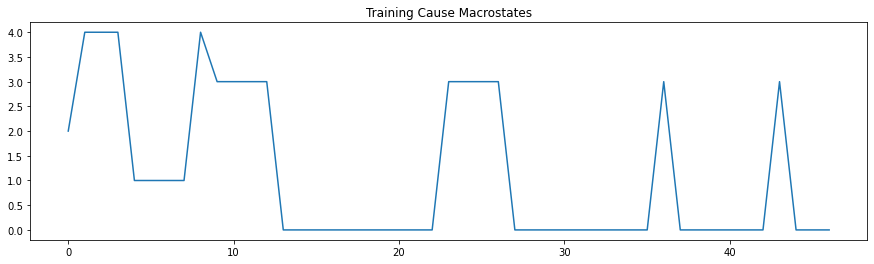

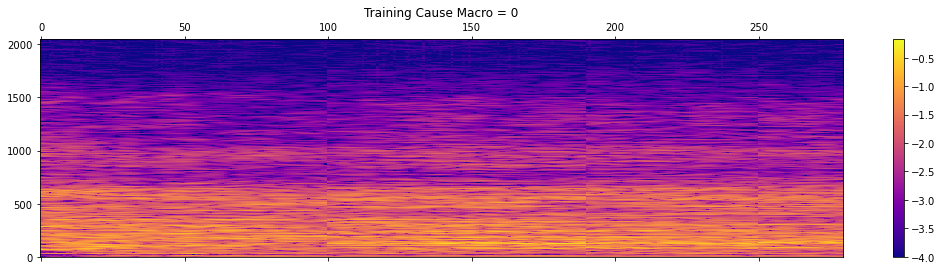

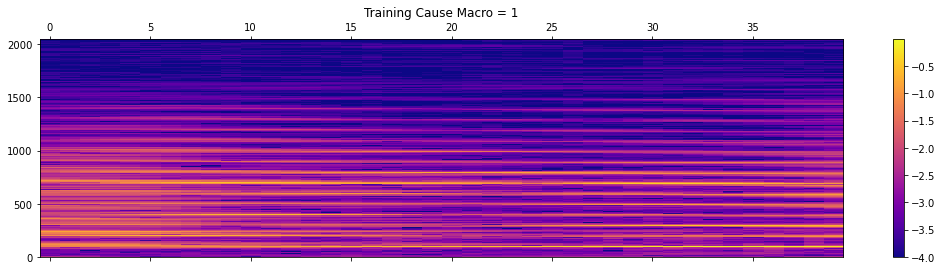

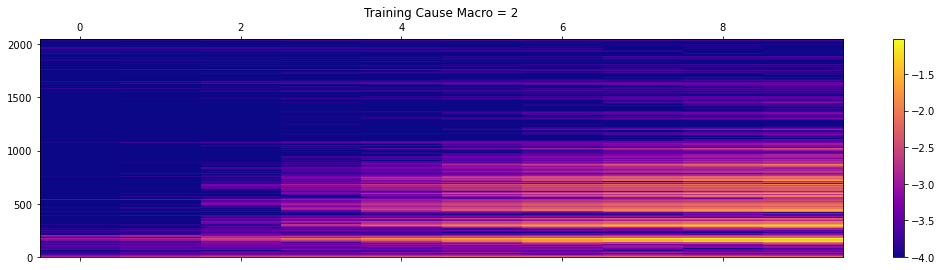

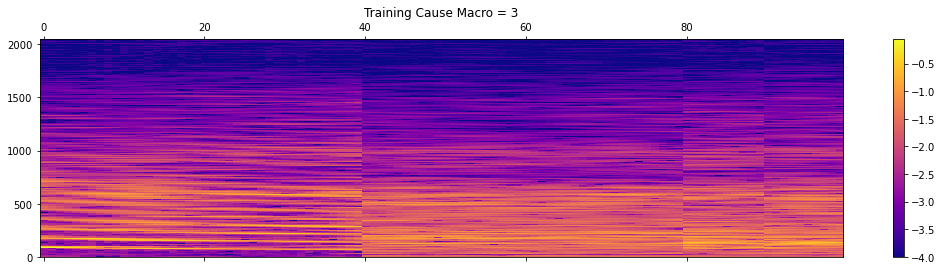

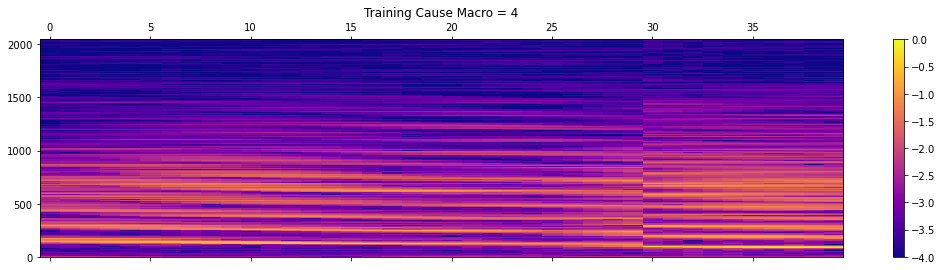

In [135]:
plt.figure(figsize = (15,4))
plt.plot(train_resultsRE['Clusterer']['x_lbls']); plt.title('Training Cause Macrostates')


causeRE0 = np.zeros((10*len(macro_cause_index['0'])), dtype = int)
causeRE1 = np.zeros((10*len(macro_cause_index['1'])), dtype = int)
causeRE2 = np.zeros((10*len(macro_cause_index['2'])), dtype = int)
causeRE3 = np.zeros((10*len(macro_cause_index['3'])), dtype = int)
causeRE4 = np.zeros((10*len(macro_cause_index['4'])), dtype = int)

for i in range(0,len(macro_cause_index['0'])):
    for j in range(0,10):
        num = 10*macro_cause_index['0'][i] + j
        ind = 10*i + j
        causeRE0[ind] = num
for i in range(0,len(macro_cause_index['1'])):
    for j in range(0,10):
        num = 10*macro_cause_index['1'][i] + j
        ind = 10*i + j
        causeRE1[ind] = num
for i in range(0,len(macro_cause_index['2'])):
    for j in range(0,10):
        num = 10*macro_cause_index['2'][i] + j
        ind = 10*i + j
        causeRE2[ind] = num
for i in range(0,len(macro_cause_index['3'])):
    for j in range(0,10):
        num = 10*macro_cause_index['3'][i] + j
        ind = 10*i + j
        causeRE3[ind] = num
for i in range(0,len(macro_cause_index['4'])):
    for j in range(0,10):
        num = 10*macro_cause_index['4'][i] + j
        ind = 10*i + j
        causeRE4[ind] = num
    

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 4))
cax = ax.matshow(np.transpose(spec1a[causeRE0,]),interpolation="nearest",aspect="auto",
    cmap='plasma',origin="lower",)
fig.colorbar(cax); plt.title("Training Cause Macro = 0")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 4))
cax = ax.matshow(np.transpose(spec1a[causeRE1,]),interpolation="nearest",aspect="auto",
    cmap='plasma',origin="lower",)
fig.colorbar(cax); plt.title("Training Cause Macro = 1")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 4))
cax = ax.matshow(np.transpose(spec1a[causeRE2,]),interpolation="nearest",aspect="auto",
    cmap='plasma',origin="lower",)
fig.colorbar(cax); plt.title("Training Cause Macro = 2")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 4))
cax = ax.matshow(np.transpose(spec1a[causeRE3,]),interpolation="nearest",aspect="auto",
    cmap='plasma',origin="lower",)
fig.colorbar(cax); plt.title("Training Cause Macro = 3")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 4))
cax = ax.matshow(np.transpose(spec1a[causeRE4,]),interpolation="nearest",aspect="auto",
    cmap='plasma',origin="lower",)
fig.colorbar(cax); plt.title("Training Cause Macro = 4")

Text(0.5, 1.0, 'Training effect Macro = 4')

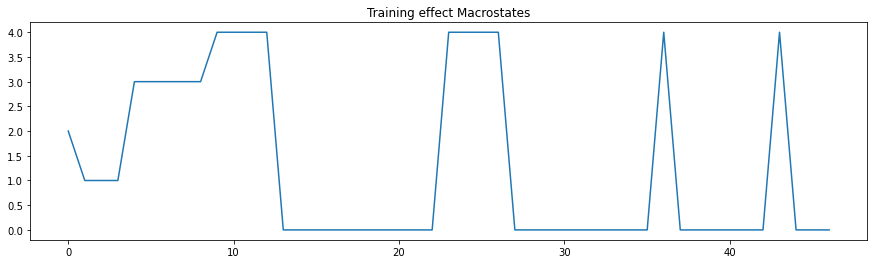

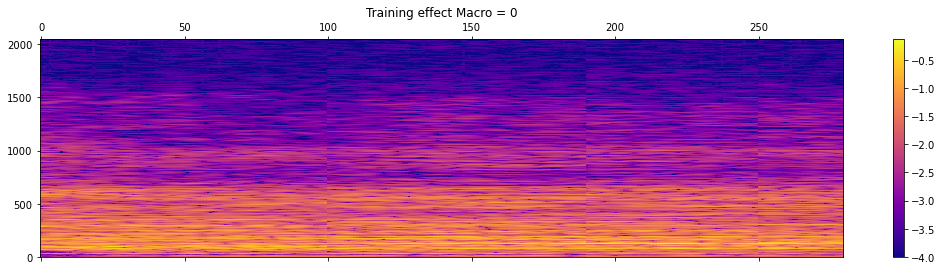

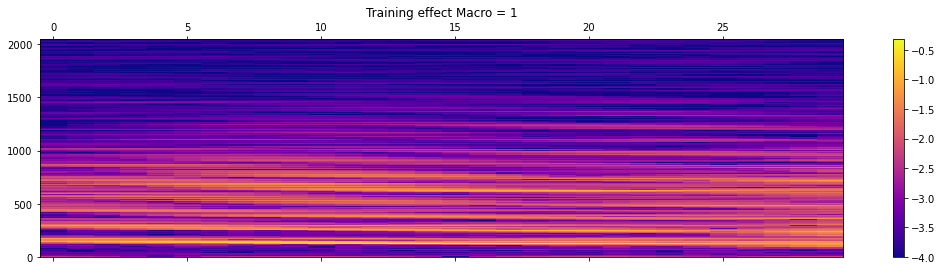

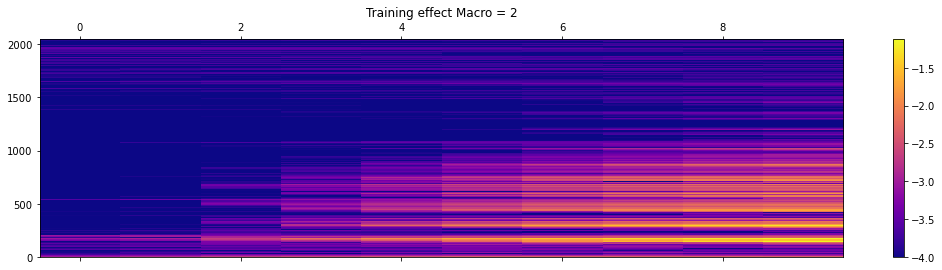

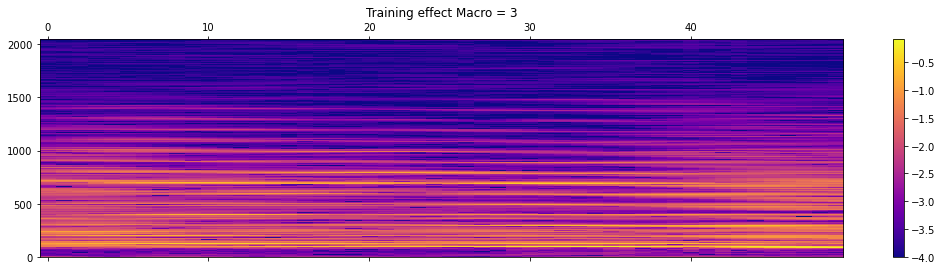

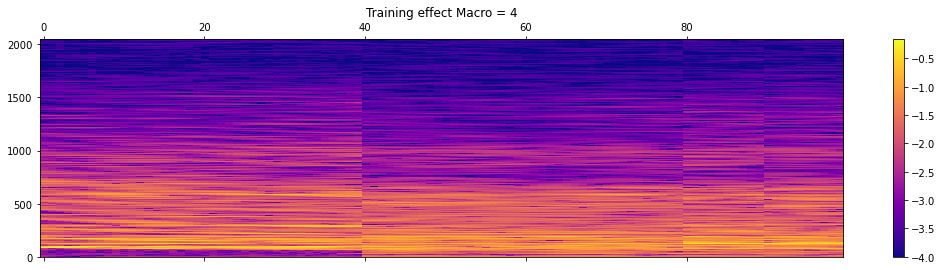

In [136]:
# plt.figure(figsize = (15,4))
# plt.plot(train_resultsRE['Clusterer']['y_lbls']); plt.title('Train Effect Macrostates')
# plt.title("Macrostates assigned to each time sample")

macro_effect_index = {"0": [], "1": [], "2": [], "3": [], "4": []}

for i in range(len(train_resultsRE['Clusterer']['y_lbls'])):
    macro_effect_index[str(train_resultsRE['Clusterer']['y_lbls'][i])].append(i)
    
    
    
plt.figure(figsize = (15,4))
plt.plot(train_resultsRE['Clusterer']['y_lbls']); plt.title('Training effect Macrostates')


effectRE0 = np.zeros((10*len(macro_effect_index['0'])), dtype = int)
effectRE1 = np.zeros((10*len(macro_effect_index['1'])), dtype = int)
effectRE2 = np.zeros((10*len(macro_effect_index['2'])), dtype = int)
effectRE3 = np.zeros((10*len(macro_effect_index['3'])), dtype = int)
effectRE4 = np.zeros((10*len(macro_effect_index['4'])), dtype = int)

for i in range(0,len(macro_effect_index['0'])):
    for j in range(0,10):
        num = 10*macro_effect_index['0'][i] + j
        ind = 10*i + j
        effectRE0[ind] = num
for i in range(0,len(macro_effect_index['1'])):
    for j in range(0,10):
        num = 10*macro_effect_index['1'][i] + j
        ind = 10*i + j
        effectRE1[ind] = num
for i in range(0,len(macro_effect_index['2'])):
    for j in range(0,10):
        num = 10*macro_effect_index['2'][i] + j
        ind = 10*i + j
        effectRE2[ind] = num
for i in range(0,len(macro_effect_index['3'])):
    for j in range(0,10):
        num = 10*macro_effect_index['3'][i] + j
        ind = 10*i + j
        effectRE3[ind] = num
for i in range(0,len(macro_effect_index['4'])):
    for j in range(0,10):
        num = 10*macro_effect_index['4'][i] + j
        ind = 10*i + j
        effectRE4[ind] = num
    

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 4))
cax = ax.matshow(np.transpose(spec2a[effectRE0,]),interpolation="nearest",aspect="auto",
    cmap='plasma',origin="lower",)
fig.colorbar(cax); plt.title("Training effect Macro = 0")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 4))
cax = ax.matshow(np.transpose(spec2a[effectRE1,]),interpolation="nearest",aspect="auto",
    cmap='plasma',origin="lower",)
fig.colorbar(cax); plt.title("Training effect Macro = 1")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 4))
cax = ax.matshow(np.transpose(spec2a[effectRE2,]),interpolation="nearest",aspect="auto",
    cmap='plasma',origin="lower",)
fig.colorbar(cax); plt.title("Training effect Macro = 2")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 4))
cax = ax.matshow(np.transpose(spec2a[effectRE3,]),interpolation="nearest",aspect="auto",
    cmap='plasma',origin="lower",)
fig.colorbar(cax); plt.title("Training effect Macro = 3")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 4))
cax = ax.matshow(np.transpose(spec2a[effectRE4,]),interpolation="nearest",aspect="auto",
    cmap='plasma',origin="lower",)
fig.colorbar(cax); plt.title("Training effect Macro = 4")

In [137]:
# average train causes 
ave1a_m0RE = sum(spec1a[causeRE0,]) / spec1a[causeRE0,].shape[0]
ave1a_m1RE = sum(spec1a[causeRE1,]) / spec1a[causeRE1,].shape[0]
ave1a_m2RE = sum(spec1a[causeRE2,]) / spec1a[causeRE2,].shape[0]
ave1a_m3RE = sum(spec1a[causeRE3,]) / spec1a[causeRE3,].shape[0]
ave1a_m4RE = sum(spec1a[causeRE4,]) / spec1a[causeRE4,].shape[0]

# average train effects
ave2a_m0RE = sum(spec2a[effectRE0,]) / spec2a[effectRE0,].shape[0]
ave2a_m1RE = sum(spec2a[effectRE1,]) / spec2a[effectRE1,].shape[0]
ave2a_m2RE = sum(spec2a[effectRE2,]) / spec2a[effectRE2,].shape[0]
ave2a_m3RE = sum(spec2a[effectRE3,]) / spec2a[effectRE3,].shape[0]
ave2a_m4RE = sum(spec2a[effectRE4,]) / spec2a[effectRE4,].shape[0]

aveEffectRE = [ave2a_m0RE, ave2a_m1RE, ave2a_m2RE, ave2a_m3RE, ave2a_m4RE]

In [138]:
print(tab1aRE)

+--------------+----+----+----+----+----+
| RE C+E Train | 0C | 1C | 2C | 3C | 4C |
+--------------+----+----+----+----+----+
|      0E      | 28 | 0  | 0  | 0  | 0  |
|      1E      | 0  | 0  | 0  | 0  | 3  |
|      2E      | 0  | 0  | 1  | 0  | 0  |
|      3E      | 0  | 4  | 0  | 0  | 1  |
|      4E      | 0  | 0  | 0  | 10 | 0  |
+--------------+----+----+----+----+----+


In [139]:
# automate linkage between cause macrostates and effect macrostates


# check max effect macrostate within each cause macrostate
REmaxed0 = max(REc0e0, REc0e1, REc0e2, REc0e3, REc0e4)
REmaxed1 = max(REc1e0, REc1e1, REc1e2, REc1e3, REc1e4)
REmaxed2 = max(REc2e0, REc2e1, REc2e2, REc2e3, REc2e4)
REmaxed3 = max(REc3e0, REc3e1, REc3e2, REc3e3, REc3e4)
REmaxed4 = max(REc4e0, REc4e1, REc4e2, REc4e3, REc4e4)

# creating lists of each macrostate to check through
REmax0, REmax1, REmax2, REmax3, REmax4 = np.zeros((5,), dtype = int)
REmaxe0 = [REc0e0, REc0e1, REc0e2, REc0e3, REc0e4]
REmaxe1 = [REc1e0, REc1e1, REc1e2, REc1e3, REc1e4]
REmaxe2 = [REc2e0, REc2e1, REc2e2, REc2e3, REc2e4]
REmaxe3 = [REc3e0, REc3e1, REc3e2, REc3e3, REc3e4]
REmaxe4 = [REc4e0, REc4e1, REc4e2, REc4e3, REc4e4]


# checks to see which effect macrostate is maxed for each cause macrostate and stores it
for i in range(0,5): 
    if REmaxe0[i] == REmaxed0:
        REmax0 = i 
for i in range(0,5):
    if REmaxe1[i] == REmaxed1:
        REmax1 = i
for i in range(0,5):
    if REmaxe2[i] == REmaxed2:
        REmax2 = i
for i in range(0,5):
    if REmaxe3[i] == REmaxed3:
        REmax3 = i
for i in range(0,5):
    if REmaxe4[i] == REmaxed4:
        REmax4 = i

print(REmax0, REmax1, REmax2, REmax3, REmax4)


# creating list of the spectrograms made up of each training effect macrostate 
REyspeclist = [spec2a[effectRE0,],spec2a[effectRE1,],spec2a[effectRE2,],spec2a[effectRE3,],spec2a[effectRE4]]

0 3 2 4 1


In [140]:
finalRandRE = np.ndarray((spec1b.shape[0], spec1b.shape[1]))
finalRandRE.shape

(472, 2048)

Text(0.5, 1.0, 'Predicted Test Effect with Random Selection')

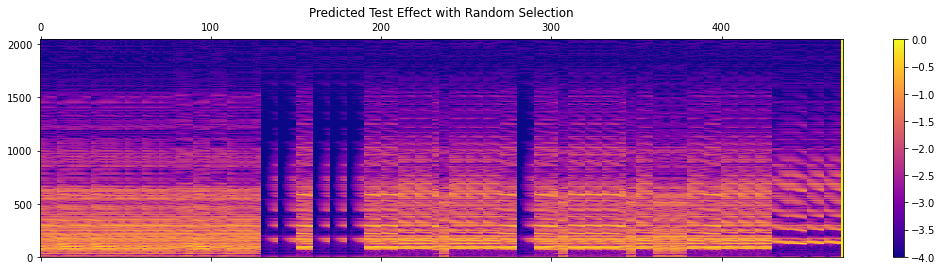

In [141]:
# test cell

finalRandRE = np.ndarray((spec1b.shape[0], spec1b.shape[1]))

for i in range(0,math.floor(len(spec1b)/10)):  
    zerom = sum( (spec1b[10*i] - ave1a_m0)**2 ) 
    onem = sum( (spec1b[10*i] - ave1a_m1)**2 )
    twom = sum( (spec1b[10*i] - ave1a_m2)**2 )
    threem = sum( (spec1b[10*i] - ave1a_m3)**2 )
    fourm = sum( (spec1b[10*i] - ave1a_m4)**2 )

    lis = (zerom, onem, twom, threem, fourm)

    # finds smallest value, meaning most similar
    if (min(lis) == zerom):
        minmacro = 0
    elif (min(lis) == onem):
        minmacro = 1
    elif (min(lis) == twom):
        minmacro = 2
    elif (min(lis) == threem):
        minmacro = 3
    elif (min(lis) == fourm):
        minmacro = 4


    if minmacro == 0:
        chunkstart0 = random.choice(macro_cause_index['0'])
        for k in range(0,10):
            finalRandRE[10*i+k] = REyspeclist[REmax0][chunkstart0+k]
    elif minmacro == 1:
            chunkstart1 = random.choice(macro_cause_index['1'])
            for k in range(0,10):
                finalRandRE[10*i+k] = REyspeclist[REmax1][chunkstart1+k]
    elif minmacro == 2:
            chunkstart2= random.choice(macro_cause_index['2'])
            for k in range(0,10):
                finalRandRE[10*i+k] = REyspeclist[REmax2][chunkstart2+k]
    elif minmacro == 3:
            chunkstart3= random.choice(macro_cause_index['3'])
            for k in range(0,10):
                finalRandRE[10*i+k] = REyspeclist[REmax3][chunkstart3+k]
    elif minmacro == 4:
            chunkstart4= random.choice(macro_cause_index['4'])
            for k in range(0,10):
                    finalRandRE[10*i+k] = REyspeclist[REmax4][chunkstart4+k]

                
                
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 4))
cax = ax.matshow(np.transpose(finalRandRE),interpolation="nearest",aspect="auto",
    cmap='plasma',origin="lower",
)
fig.colorbar(cax)
plt.title("Predicted Test Effect with Random Selection")

In [142]:
# for each slice in test cause, compare to the average train cause

finalRandRE = np.ndarray((spec1b.shape[0], spec1b.shape[1]))
finalAveRE =  np.ndarray((spec1b.shape[0], spec1b.shape[1]))

for i in range(0,math.floor(len(spec1b)/10)):

    # checking how similar each starting slice of a chunk for test cause is to training cause
    zerom = sum( (spec1b[10*i] - ave1a_m0)**2 ) 
    onem = sum( (spec1b[10*i] - ave1a_m1)**2 )
    twom = sum( (spec1b[10*i] - ave1a_m2)**2 )
    threem = sum( (spec1b[10*i] - ave1a_m3)**2 )
    fourm = sum( (spec1b[10*i] - ave1a_m4)**2 )

    lis = (zerom, onem, twom, threem, fourm)

    # finds smallest value, meaning most similar
    if (min(lis) == zerom):
        minmacro = 0
    elif (min(lis) == onem):
        minmacro = 1
    elif (min(lis) == twom):
        minmacro = 2
    elif (min(lis) == threem):
        minmacro = 3
    elif (min(lis) == fourm):
        minmacro = 4


    # take minmacro, and get the connected training effect macrostate
    # use the average value from the training effect as predicted effect

    # using average values
#     for j in range(0,10):
#         if minmacro == 0:
#             finalAveRE[i] = aveEffectRE[REmax0]
#         elif minmacro == 1:
#             finalAveRE[i] = aveEffectRE[REmax1]
#         elif minmacro == 2:
#             finalAveRE[i] = aveEffectRE[REmax2]
#         elif minmacro == 3:
#             finalAveRE[i] = aveEffectRE[REmax3]
#         elif minmacro == 4:
#             finalAveRE[i] = aveEffectRE[REmax4]

        # using random slices from the relevant training effect macrostate

    if minmacro == 0:
        chunkstart0 = random.choice(macro_cause_index['0']) # chooses a random starting point for the slice
        for k in range(0,10):
            finalRandRE[10*i+k] = REyspeclist[REmax0][chunkstart0+k] # plugs in the starting point and the subsequent 9 values into the prediction
    elif minmacro == 1:
        chunkstart1 = random.choice(macro_cause_index['1'])
        for k in range(0,10):
            finalRandRE[10*i+k] = REyspeclist[REmax1][chunkstart1+k]
    elif minmacro == 2:
        chunkstart2= random.choice(macro_cause_index['2'])
        for k in range(0,10):
            finalRandRE[10*i+k] = REyspeclist[REmax2][chunkstart2+k]
    elif minmacro == 3:
        chunkstart3= random.choice(macro_cause_index['3'])
        for k in range(0,10):
            finalRandRE[10*i+k] = REyspeclist[REmax3][chunkstart3+k]
    elif minmacro == 4:
        chunkstart4= random.choice(macro_cause_index['4'])
        for k in range(0,10):
            finalRandRE[10*i+k] = REyspeclist[REmax4][chunkstart4+k]


# spec1b.shape = (472, 2048)

In [143]:
macro_cause_index['4']
chunkstart4 = random.choice(macro_cause_index['4'])
REyspeclist[REmax4]

array([[-2.55133953, -2.38868   , -2.44468321, ..., -3.96899013,
        -3.87098458, -3.6480049 ],
       [-2.64754985, -2.4292793 , -2.45774755, ..., -3.69564641,
        -3.94761107, -3.70688999],
       [-2.8271373 , -2.48942219, -2.48794342, ..., -3.70532282,
        -3.77551046, -3.54102703],
       ...,
       [-2.83241392, -2.70780755, -2.31287215, ..., -3.99847287,
        -3.800028  , -3.59015577],
       [-2.84234787, -2.83360713, -2.35712713, ..., -4.        ,
        -3.76304   , -3.62070604],
       [-2.94712325, -3.03265625, -2.41064907, ..., -4.        ,
        -3.75973484, -3.66250847]])

Text(0.5, 1.0, 'Actual Test Effect')

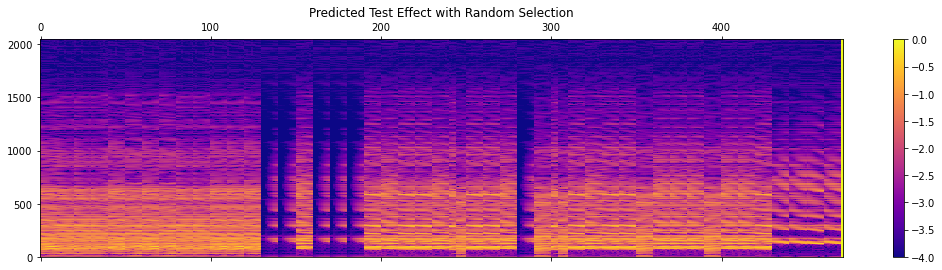

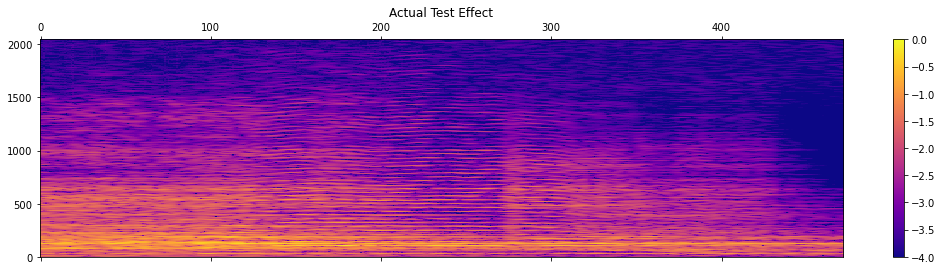

In [144]:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 4))
# cax = ax.matshow(np.transpose(finalAveRE),interpolation="nearest",aspect="auto",
#     cmap='plasma',origin="lower",
# )
# fig.colorbar(cax)
# plt.title("Predicted Test Effect with Averaged Specs")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 4))
cax = ax.matshow(np.transpose(finalRandRE),interpolation="nearest",aspect="auto",
    cmap='plasma',origin="lower",
)
fig.colorbar(cax)
plt.title("Predicted Test Effect with Random Selection")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 4))
cax = ax.matshow(np.transpose(spec2b),interpolation="nearest",aspect="auto",
    cmap='plasma',origin="lower",
)
fig.colorbar(cax)
plt.title("Actual Test Effect")

In [145]:
# inverted spec of predicted effect Average

# invertpredAveRE = invert_pretty_spectrogram(
#     finalAveRE, fft_size=fft_size, step_size=step_size, log=True, n_iter=10
# )
# IPython.display.Audio(data=invertpredAveRE, rate=rate) 

In [146]:
# inverted spec of predicted effect Random
invertpredRandRE = invert_pretty_spectrogram(
    finalRandRE, fft_size=fft_size, step_size=step_size, log=True, n_iter=10
)
IPython.display.Audio(data=invertpredRandRE, rate=rate) 

In [147]:
# inverted spec of actual effect
invertorig = invert_pretty_spectrogram(
    spec2b, fft_size=fft_size, step_size=step_size, log=True, n_iter=10
)
IPython.display.Audio(data=invertorig, rate=rate)

**********
## Flipped Visualizations
[Top](#CFL-using-Reverberations)

###### a bit of broken stuff in here, not worth fixing rn might get removed

In [ ]:
plt.figure(figsize = (17,13))
plt.title('Graphed Macrostates 2')
plt.subplot(4,1,1); plt.plot(train_results2['Clusterer']['x_lbls']); plt.title('Spec2a: Reverb Part 1')
plt.subplot(4,1,2); plt.plot(train_results2['Clusterer']['y_lbls']); plt.title('Spec1a: Original Part 1')
plt.subplot(4,1,3); plt.plot(pred_results2['Clusterer']['x_lbls']); plt.title('Spec2b: Reverb Part 2')
plt.subplot(4,1,4); plt.plot(pred_results2['Clusterer']['y_lbls']); plt.title('Spec1b: Original Part 2')

###### Training on Reverb Seems to perform better

In [ ]:
# this isn't super meaningful rn with reverb
trainxl = train_results['Clusterer']['x_lbls']
trainyl = train_results['Clusterer']['y_lbls']
predxl = pred_results['Clusterer']['x_lbls']
predyl = pred_results['Clusterer']['y_lbls']

macroviz = np.append(np.append(trainxl, trainyl), np.append(predxl, predyl))
plt.figure(figsize = (17,4)); plt.title('Macrostates, trained on Spec1a, Spec2a, then applied to Spec1b, Spec2b')
plt.plot(macroviz, color = 'red'); plt.axvline(x=236, color = 'black'); plt.axvline(x=2*236, color = 'black'); plt.axvline(x=3*236, color = 'black')

## Spec1

In [ ]:
IPython.display.Audio( data = data[0:61184], rate = rate)

In [ ]:
plt.figure(figsize = (17,4))
plt.title('Spec1')
plt.plot(train_results['Clusterer']['x_lbls'])

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
cax = ax.matshow(np.transpose(spec1),interpolation="nearest",aspect="auto",
    cmap='plasma',origin="lower",) ;fig.colorbar(cax); plt.title("Spec1")

## Spec2

In [ ]:
IPython.display.Audio( data = data[61184:2*61184], rate = rate)

In [ ]:
plt.figure(figsize = (17, 4)); plt.title('Spec2'); plt.plot(train_results['Clusterer']['y_lbls'])

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
cax = ax.matshow(np.transpose(spec2),interpolation="nearest",aspect="auto",
    cmap='plasma',origin="lower",); fig.colorbar(cax); plt.title("Spec2")

## Spec3

In [ ]:
IPython.display.Audio( data = data[2*61184:3*61184], rate = rate)

In [ ]:
plt.figure(figsize = (17, 4)); plt.title('Spec3'); plt.plot(pred_results['Clusterer']['x_lbls'])

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
cax = ax.matshow(np.transpose(spec3),interpolation="nearest",aspect="auto",
    cmap='plasma',origin="lower",); fig.colorbar(cax); plt.title("Spec3")

## Spec4

In [ ]:
IPython.display.Audio( data = data[3*61184:4*61184], rate = rate)

In [ ]:
plt.figure(figsize = (17, 4)); plt.title('Spec4'); plt.plot(pred_results['Clusterer']['y_lbls'])

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
cax = ax.matshow(np.transpose(spec4),interpolation="nearest",aspect="auto",
    cmap='plasma',origin="lower",); fig.colorbar(cax); plt.title("Spec4")

*******************************************************************************************************************************
*********
# Line Segments
[Top](#CFL-using-Reverberations)

##### this was hard coded for an example which changed, I need to make it general, might not be needed

## Spec 1 -> 2

In [ ]:
train_results['Clusterer']['x_lbls'][0:48]

In [ ]:
plt.title('Macro X'); plt.plot(train_results['Clusterer']['x_lbls'][0:48])

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
cax = ax.matshow(np.transpose(spec1[0:48]),interpolation="nearest",aspect="auto",
    cmap='plasma',origin="lower",); fig.colorbar(cax); plt.title("Spec1 MacroX = 1")

comparing to the other spot where spec1 macroX = 3

In [ ]:
#train_results['Clusterer']['x_lbls'][95:106]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
cax = ax.matshow(np.transpose(spec1[95:106]),interpolation="nearest",aspect="auto",
    cmap='plasma',origin="lower",); fig.colorbar(cax); plt.title("Spec1 MacroX = 3 Part 2")

In [ ]:
plt.title('Macro Y'); plt.plot(train_results['Clusterer']['y_lbls'][0:38])

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
cax = ax.matshow(np.transpose(spec2[0:38]),interpolation="nearest",aspect="auto",
    cmap='plasma',origin="lower",); fig.colorbar(cax); plt.title("Spec2 MacroY = 2")

## Spec 3 -> 4

In [ ]:
plt.figure(figsize = (17, 4)); plt.title('Spec3 MacroX=1');plt.plot(pred_results['Clusterer']['x_lbls'][0:127])

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
cax = ax.matshow(np.transpose(spec3[0:127]),interpolation="nearest",aspect="auto",
    cmap='plasma',origin="lower",); fig.colorbar(cax); plt.title("Spec3 MacroX = 1")

In [ ]:
plt.figure(figsize = (17,4)); plt.title('Spec3 MacroX = 0'); plt.plot(pred_results['Clusterer']['x_lbls'][128:138])

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
cax = ax.matshow(np.transpose(spec3[128:138]),interpolation="nearest",aspect="auto",
    cmap='plasma',origin="lower",); fig.colorbar(cax); plt.title("Spec3 MacroX = 0")

comparing to the other line segment where MacroX = 0

In [ ]:
#pred_results['Clusterer']['x_lbls'][190:217]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
cax = ax.matshow(np.transpose(spec3[190:217]),interpolation="nearest",aspect="auto",
    cmap='plasma',origin="lower",); fig.colorbar(cax); plt.title("Spec3 MacroX = 0 Part 2")

In [ ]:
plt.figure(figsize = (17,4)); plt.title('Spec4 MacroY'); plt.plot(pred_results['Clusterer']['y_lbls'][0:78])

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
cax = ax.matshow(np.transpose(spec4[0:78]),interpolation="nearest",aspect="auto",
    cmap='plasma',origin="lower",); fig.colorbar(cax); plt.title("Spec4 MacroY")